# Exploring US Education DATA for a clearer ranking

<b>Belhal Karimi</b>

<p style="font-family: Verdana; ">This document aims to show a new way of exploring the College Scorecard dataset recently published by the U.S. Department of Education: https://collegescorecard.ed.gov/data/. <br>
The Economist triggered discussion about this dataset in an article describing a ranking system based only on earnings after graduation: http://www.economist.com/blogs/graphicdetail/2015/10/value-university <br>
To explore trends in the data, we are going to use BayesDB.</p>

<p style="font-family: Verdana; ">BayesDB is a Bayesian database that lets users query the probable implications of their data as easily as a SQL database lets them query the data itself. Using the built-in Bayesian Query Language (BQL), users with no statistics training can solve basic data science problems, such as detecting predictive relationships between variables, inferring missing values, simulating probable observations, and identifying statistically similar database entries.<br>
BayesDB is suitable for analyzing complex, heterogeneous data tables with up to tens of thousands of rows and hundreds of variables. No preprocessing or parameter adjustment is required, though experts can override BayesDB's default assumptions when appropriate.<br>
BayesDB’s inferences are based in part on CrossCat, a new, nonparametric Bayesian machine learning method that automatically estimates the full joint distribution behind arbitrary data tables.<br>
In this particular example, we analyze a dataset of 1000 thousands rows and 50 columns (reduced from the original shape of 7000 rows and 1700 columns). And along the study, we will add some more rows and variables to test our model
</p>

# Problem Statement

<p style="font-family: Verdana; ">In October 2015, the Economist article “The value of university: Our first-ever college rankings" discussed the different U.S. colleges rankings published year after year. According to this article, these rankings barely reflect how much universities help their students. What's more, the article was published right after the U.S. Department of Education unveiled a huge dataset about universities. The issue is that traditional rankings of American colleges do not focus on many variables related to graduates’ earnings. In the meantime, the challenge here is to be able to compute a transparent value-added for each college in order to quantify the salary boost the students are receiving from attending such schools. The underlying issue here is that current rankings prefer translating the opportunities given by a school, via its network, its partnerships... and not on the hard working and intelligence qualities of their graduates.</p>

#Dataset

<p style="font-family: Verdana; ">The dataset published by the U.S. Department of Education is composed of 18 years (from 1996 to 2013) of data about more than 7,000 schools. More than 1,700 variables have been measured each year for each university. The number of universities fluctuates according to the creation of new schools and the closing of existing ones.<br><br>
<b>The overall dataset contains more than 215 million values with 43% of them missing  </b>. <br>Figure 1 highlights the variables measured each year. Obviously, we've been able to measure more and more variables through the years, but for some reason many data are missing in 2013 (the last year this study has been conducted). Obama's administration college database is way more transparent and better quality. It has better data on family income, family education levels of entering students and more sophisticated measures of degree completion as well as loan repayment. These numbers have been generated in particular by matching students’ loans to their actual tax returns. . As a result, we are able to compare professionals earnings to their students characteristics.<br><br>
Note: : The data only includes students who applied for financial aid and thus is missing all the students with well-off parents. Also, as the earnings data only take into consideration 10 years after starting college, one could argue that this scope of time is too small to include future high earners, as they would still be students (e.g. Ph.D., post-doctorate).</p>

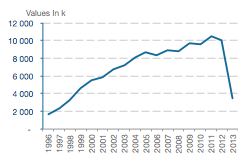

In [1]:
from IPython.display import Image
Image(filename='nan.png') 

<p style="font-family: Verdana; ">The number of schools from a year to another is also varying <br>
Here is an overview of how many schools we have metrics of.<br>
One can tell that the overall trends is showing an increase in number of schools even though from 1996 to 1998 we can observe more schools closing than being created.<br>
One intersting result could be to caracterize the fall of trends of these schools and be able to predict future outlook of current schools based on their most recent data.</p>

In [1]:
# Load the overall education dataset into a local instance of bayeslite
import bayeslite
import bdbcontrib
from bdbcontrib.recipes import quickstart
edall = quickstart(name='dfall', bdb_path='dfall.bdb')
qall = edall.q

/Applications/Bayeslite-v0.1.6rc0.app/Contents/MacOS/venv/lib/python2.7/site-packages/bayeslite/remote.py:58: UserWarning: Bayeslite is not up to date.
You are running 0.1.6rc0; the latest version is 0.1.6.
See <http://probcomp.csail.mit.edu/bayesdb>.
  warnings.warn(outofdate_warning)
:0: FutureWarning: IPython widgets are experimental and may change in the future.


BQL [SELECT COUNT(*) FROM "dfall"] [()]
BQL [
        CREATE GENERATOR "dfall_cc" IF NOT EXISTS FOR "dfall" USING crosscat( GUESS(*) )] [()]


In [2]:
edall.analysis_status()

BQL [SELECT iterations FROM bayesdb_generator_model
                           WHERE generator_id = (
                            SELECT id FROM bayesdb_generator WHERE name = ?)] [('dfall_cc',)]


,count of models
iterations,


Here is how many school there are from a year to another

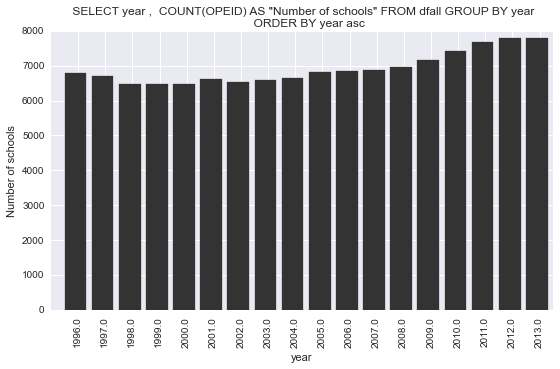

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
bdball = bayeslite.bayesdb_open("dfall.bdb", builtin_metamodels=False)
bdbcontrib.barplot(bdball, '''
SELECT year , 
COUNT(OPEID) AS "Number of schools"
FROM dfall
GROUP BY year
ORDER BY year asc
''');
plt.savefig('school_evo')

Our 57 variables include some financials and specs about the univserisites.<br>
Here is a full list of the variables selected for the study

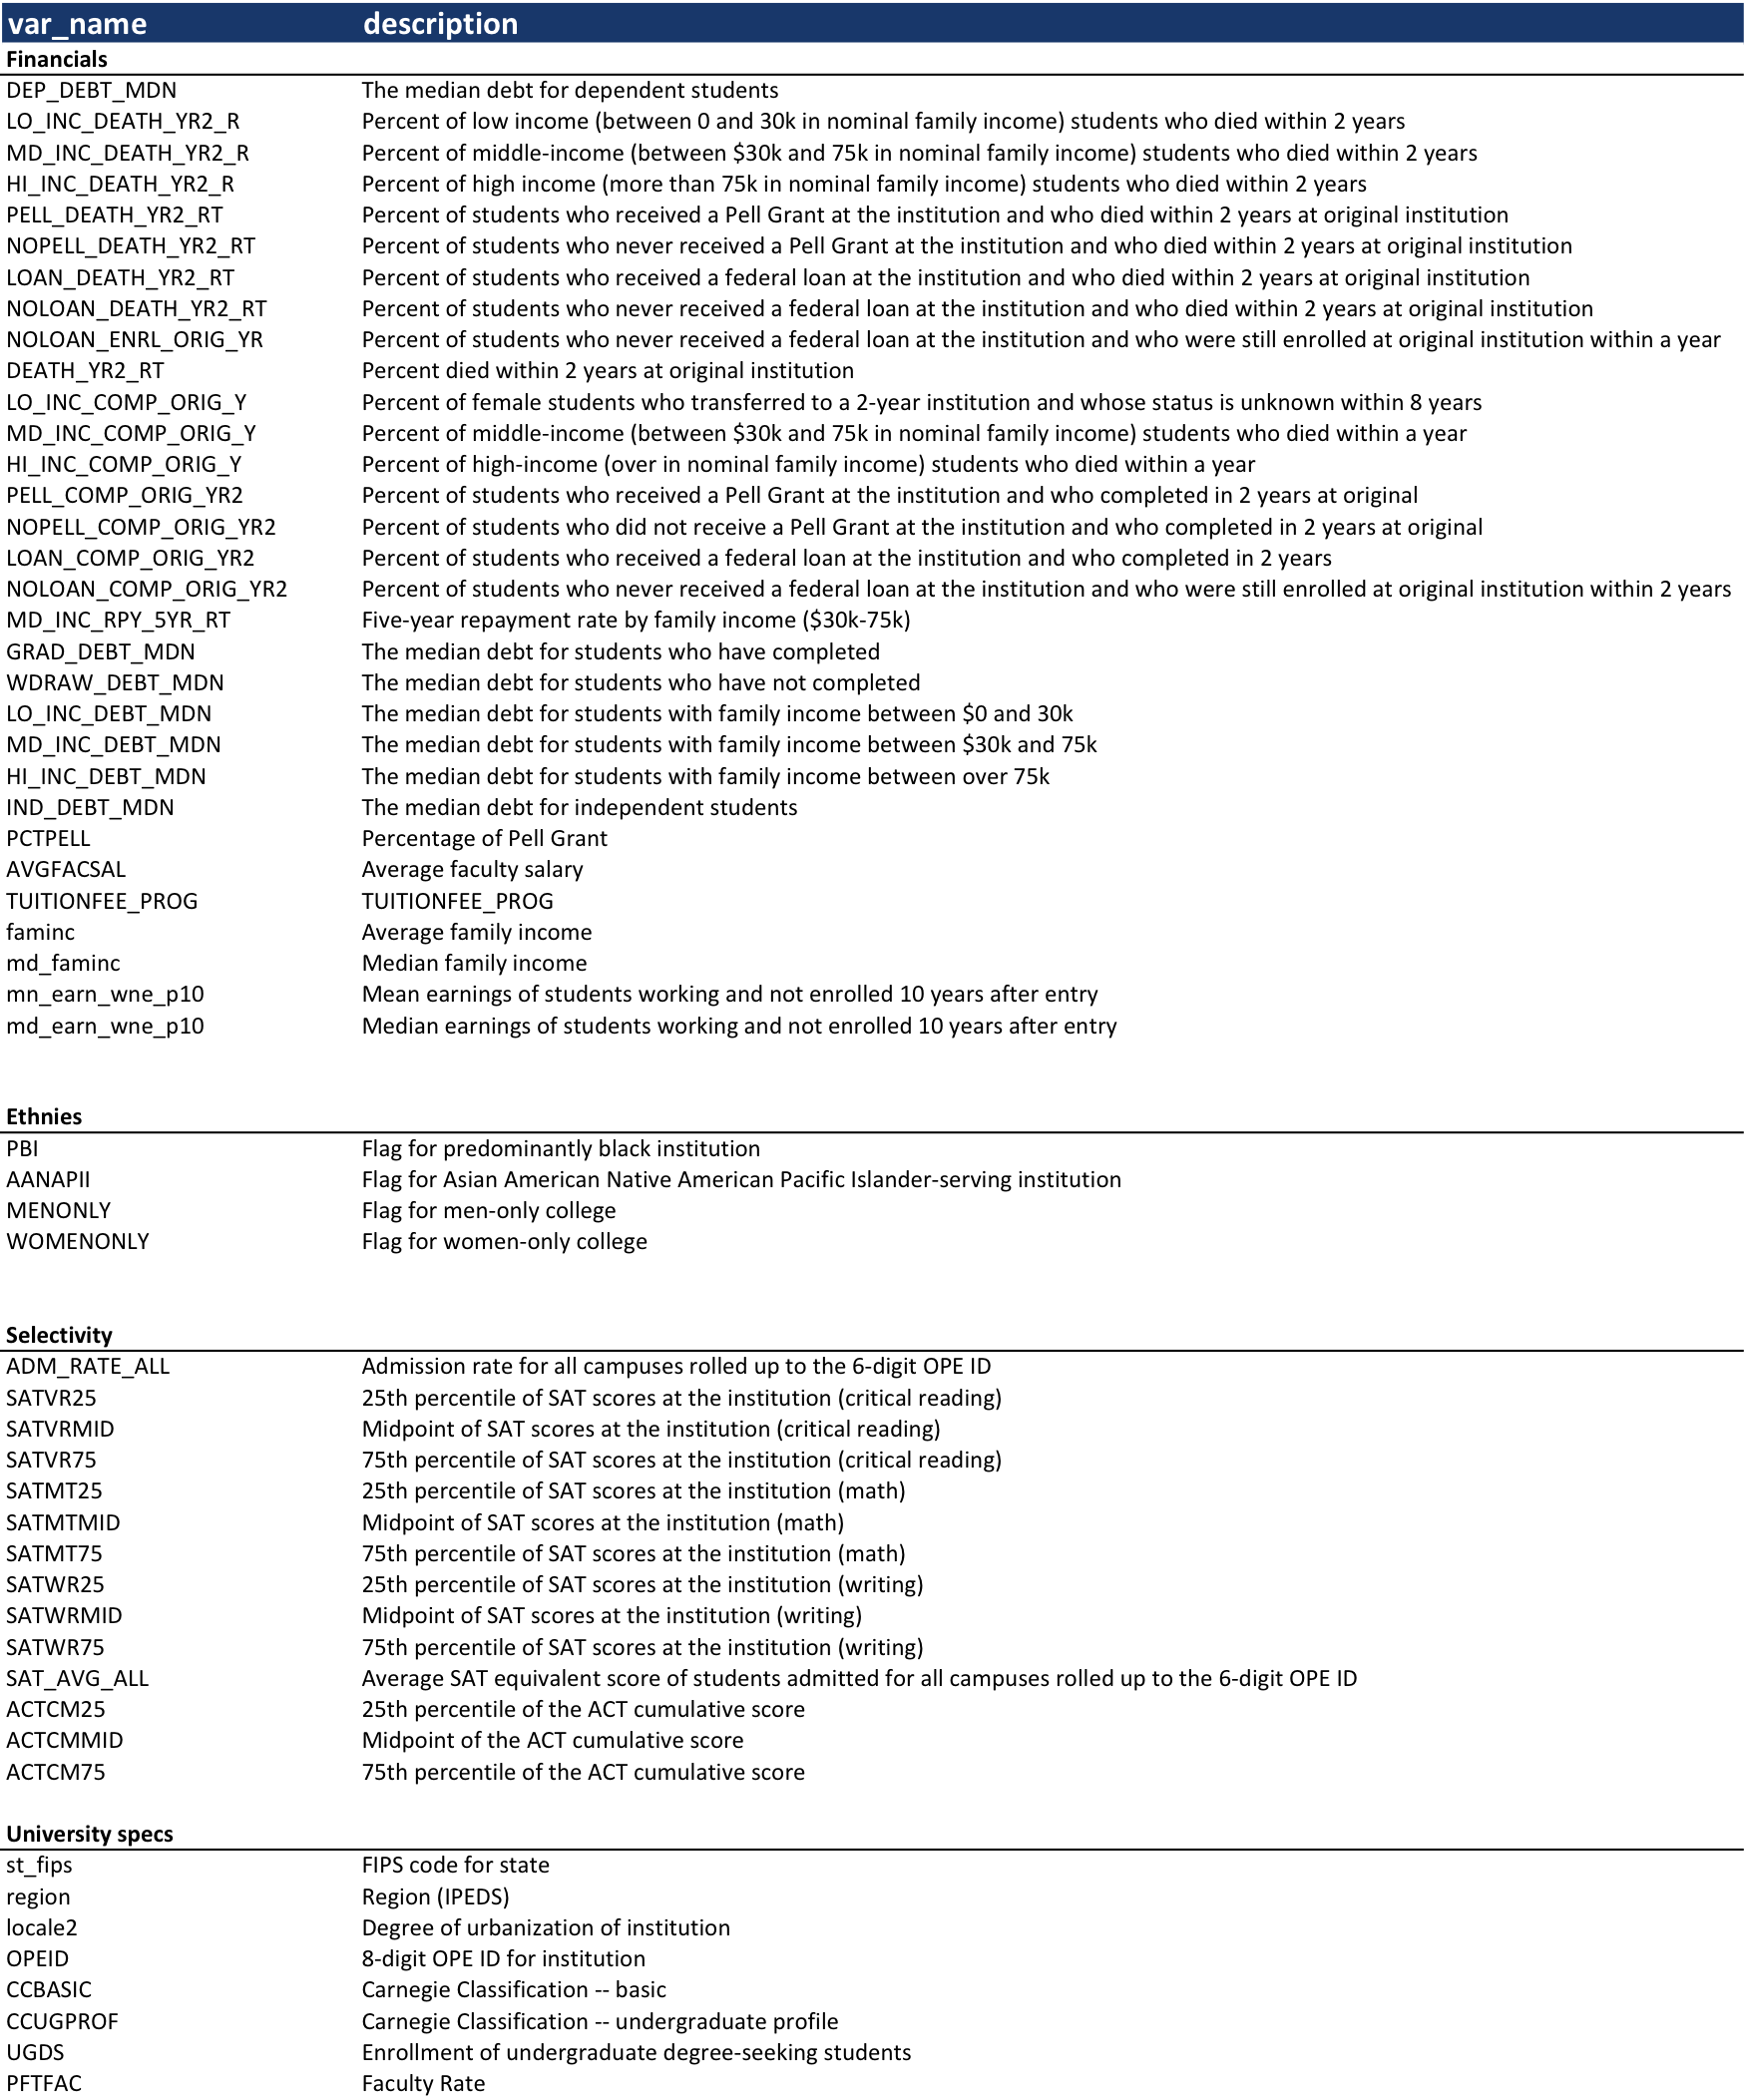

In [5]:
from IPython.display import Image
Image(filename='exp.png') 

This whole study will try to give you a good sense of what the models generated by CrossCat are actually telling you on the dataset.<br>
The fact that this dataset is related to social sciences, the advocacy we'll be making can match your commonsense on the subject. In other words, we'll focus on simple relations between variables to see that BayesDB is telling us what's expected.

Let's start by loading our bdb file of a subset of 100 rows and 57 variables that has been analyzed for 10 iterations in 16 models

In [5]:
import pandas as pd
import crosscat
from bdbcontrib.recipes import quickstart
import bayeslite
from bayeslite.read_pandas import bayesdb_read_pandas_df
DATA = pd.read_csv("Most+Recent+Cohorts+(All+Data+Elements).csv", delimiter=',', low_memory = False)
dfa =DATA.loc[:,['PFTFAC','UGDS','CCUGPROF','CCBASIC','locale2','region','st_fips','ACTCM75','ACTCMMID','ACTCM25','SAT_AVG_ALL','SATWR75','SATWRMID','SATWR25','SATMT75','SATMTMID','SATMT25','SATVR75','SATVRMID','SATVR25','ADM_RATE_ALL','WOMENONLY','MENONLY','AANAPII','PBI','md_earn_wne_p10','mn_earn_wne_p10','md_faminc','faminc','TUITIONFEE_PROG','AVGFACSAL','PCTPELL','IND_DEBT_MDN','HI_INC_DEBT_MDN','MD_INC_DEBT_MDN','LO_INC_DEBT_MDN','WDRAW_DEBT_MDN','GRAD_DEBT_MDN','MD_INC_RPY_5YR_RT','NOLOAN_COMP_ORIG_YR2','LOAN_COMP_ORIG_YR2','NOPELL_COMP_ORIG_YR2','PELL_COMP_ORIG_YR2','HI_INC_COMP_ORIG_Y','MD_INC_COMP_ORIG_Y','LO_INC_COMP_ORIG_Y','DEATH_YR2_RT','NOLOAN_ENRL_ORIG_YR','NOLOAN_DEATH_YR2_RT','LOAN_DEATH_YR2_RT','NOPELL_DEATH_YR2_RT','PELL_DEATH_YR2_RT','HI_INC_DEATH_YR2_R','MD_INC_DEATH_YR2_R','LO_INC_DEATH_YR2_R','DEP_DEBT_MDN']] 
dfa.columns = ['Faculty Rate','Enrollment of undergraduate degree-seeking students','Carnegie Classification -- undergraduate profile','Carnegie Classification -- basic','Degree of urbanization of institution','Region (IPEDS)','FIPS code for state','75th percentile of the ACT cumulative score','Midpoint of the ACT cumulative score','25th percentile of the ACT cumulative score','Average SAT equivalent score of students admitted for all campuses rolled up to the 6-digit OPE ID','75th percentile of SAT scores at the institution (writing)','Midpoint of SAT scores at the institution (writing)','25th percentile of SAT scores at the institution (writing)','75th percentile of SAT scores at the institution (math)','Midpoint of SAT scores at the institution (math)','25th percentile of SAT scores at the institution (math)','75th percentile of SAT scores at the institution (critical reading)','Midpoint of SAT scores at the institution (critical reading)','25th percentile of SAT scores at the institution (critical reading)','Admission rate for all campuses rolled up to the 6-digit OPE ID','Flag for women-only college','Flag for men-only college','Flag for Asian American Native American Pacific Islander-serving institution','Flag for predominantly black institution','Median earnings of students working and not enrolled 10 years after entry','Mean earnings of students working and not enrolled 10 years after entry','Median family income','Average family income','TUITIONFEE_PROG','Average faculty salary','Percentage of Pell Grant','The median debt for independent students','The median debt for students with family income between over 75k','The median debt for students with family income between $30k and 75k','The median debt for students with family income between $0 and 30k','The median debt for students who have not completed','The median debt for students who have completed','Five-year repayment rate by family income ($30k-75k)','Percent of students who never received a federal loan at the institution and who were still enrolled at original institution within 2 years','Percent of students who received a federal loan at the institution and who completed in 2 years ','Percent of students who did not receive a Pell Grant at the institution and who completed in 2 years at original ','Percent of students who received a Pell Grant at the institution and who completed in 2 years at original ','Percent of high-income (over in nominal family income) students who died within a year','Percent of middle-income (between $30k and 75k in nominal family income) students who died within a year','Percent of female students who transferred to a 2-year institution and whose status is unknown within 8 years','Percent died within 2 years at original institution','Percent of students who never received a federal loan at the institution and who were still enrolled at original institution within a year','Percent of students who never received a federal loan at the institution and who died within 2 years at original institution','Percent of students who received a federal loan at the institution and who died within 2 years at original institution','Percent of students who never received a Pell Grant at the institution and who died within 2 years at original institution','Percent of students who received a Pell Grant at the institution and who died within 2 years at original institution','Percent of high income (more than 75k in nominal family income) students who died within 2 years','Percent of middle-income (between $30k and 75k in nominal family income) students who died within 2 years','Percent of low income (between 0 and 30k in nominal family income) students who died within 2 years','The median debt for dependent students']
dfa = dfa.iloc[0:100,:]
bayesdb_read_pandas_df(bdb, "tab100", dfa, create=True)

ValueError: Table already exists: 'tab100'

In [26]:
ed100 = quickstart(name='tab100', bdb_path='exp.bdb')
q = ed100.q

BQL [SELECT COUNT(*) FROM "tab100"] [()]
BQL [
        CREATE GENERATOR "tab100_cc" IF NOT EXISTS FOR "tab100" USING crosscat( GUESS(*) )] [()]


In [27]:
ed100.analysis_status()

BQL [SELECT iterations FROM bayesdb_generator_model
                           WHERE generator_id = (
                            SELECT id FROM bayesdb_generator WHERE name = ?)] [('tab100_cc',)]


,count of models
iterations,
10,16


BQL [ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF "tab100_cc"] [()]


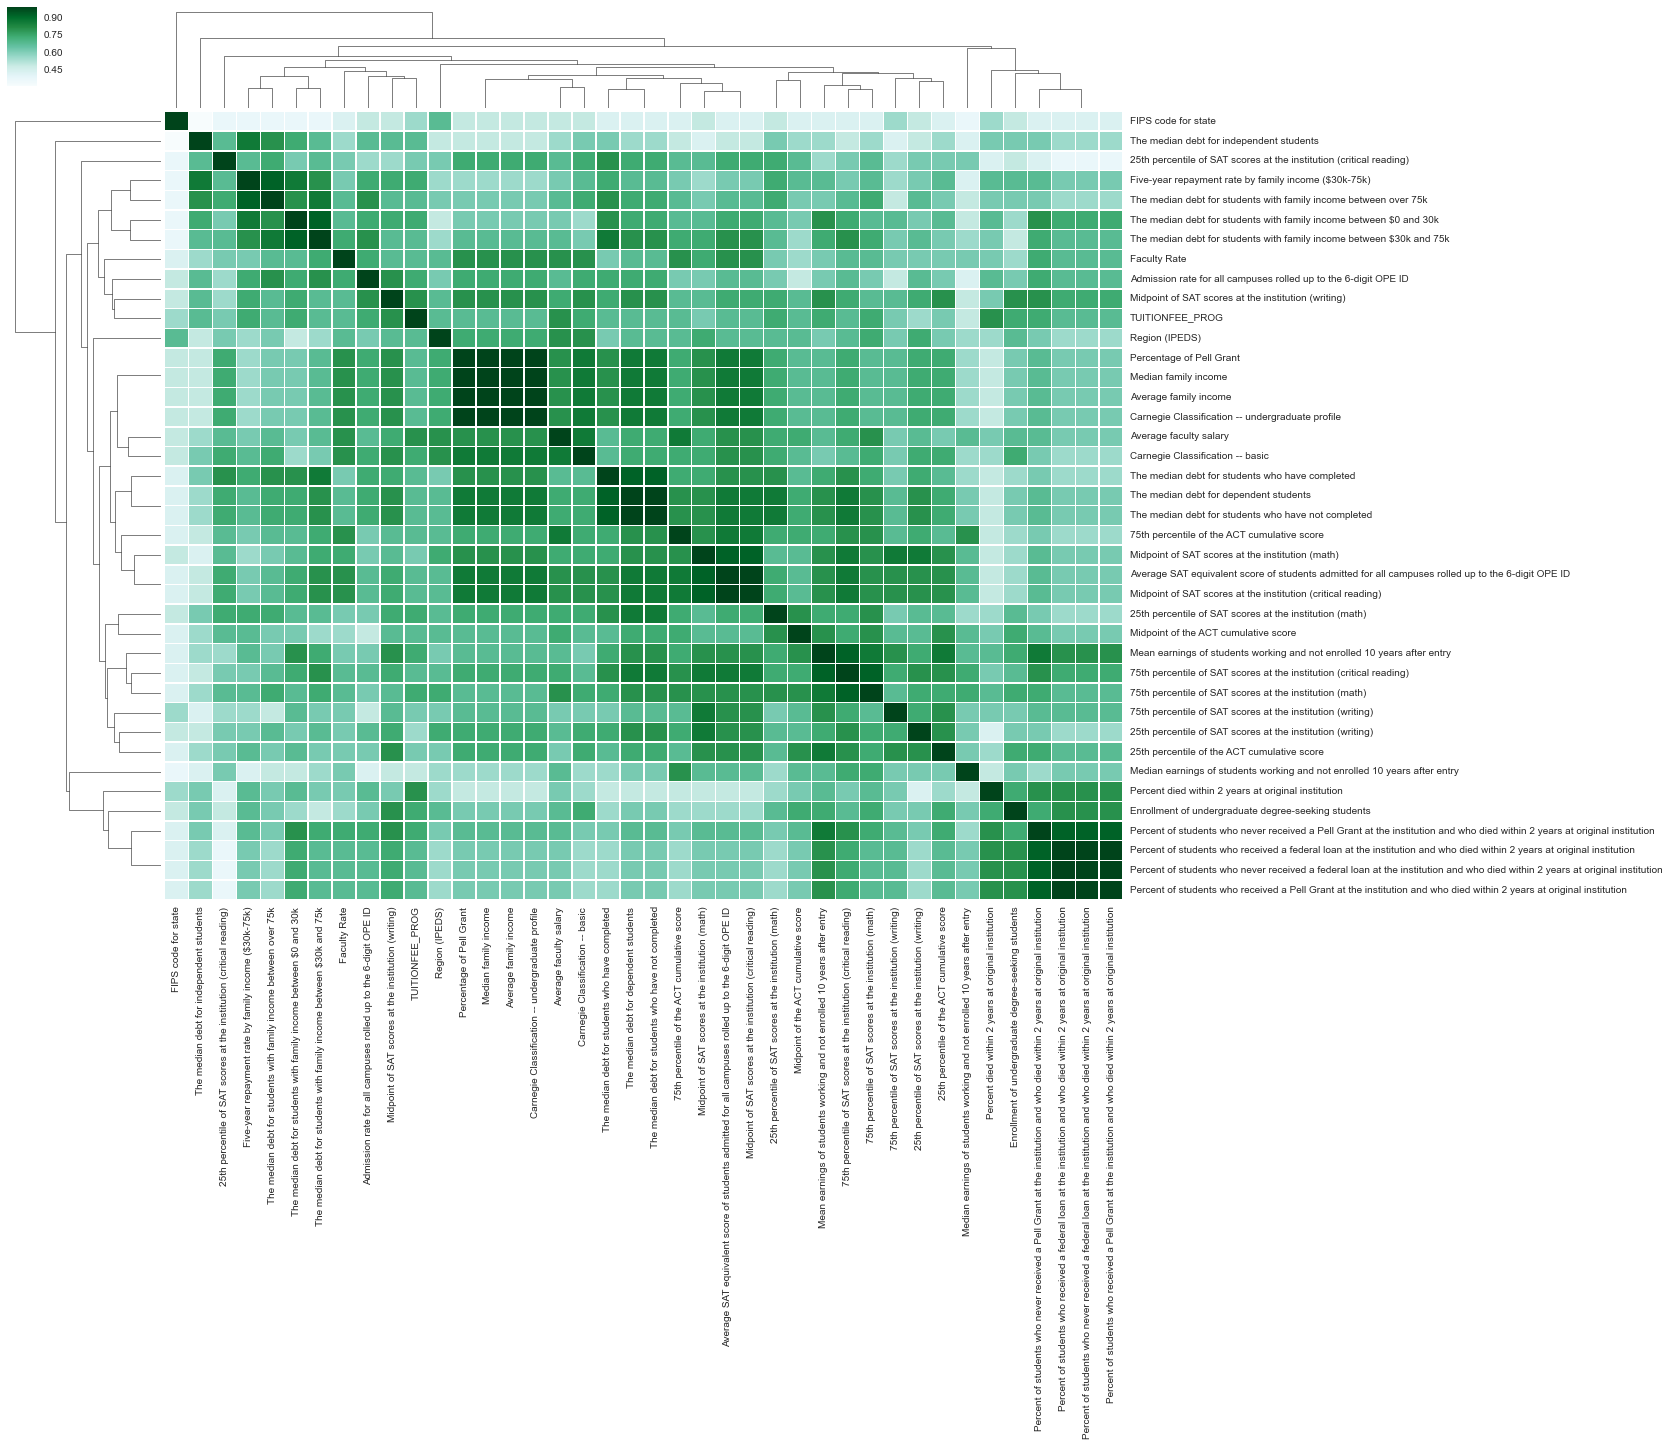

In [28]:
ed100.heatmap(ed100.q('''ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF %g'''))

Obviously, we were expecting this kind of result, meaning that no real dependant component are clear cut.<br>
Even though varibales related to SAT scores and ACT scores are expected to be strongly dependant, it is not obvious on our previous heatmap since the number of observation is too low in order for BayesDB to make such strong assumptions of dependencies 

Yet, some small blocks are clearly connected such as Percentage of Pell Grant, Median family income and average family income. For some reason, the "Carnegie Classification -- undergraduate profile" variable is also connected to this block. <br><br>
<b>Note: </b> The Undergraduate Profile Classification describes the undergraduate population with respect to three characteristics: the proportion of undergraduate students who attend part- or full-time; achievement characteristics of first-year, first-time students; and the proportion of entering students who transfer in from another institution.

In [30]:
q('select "Carnegie Classification -- undergraduate profile" from tab100 LIMIT 5')

BQL [select "Carnegie Classification -- undergraduate profile" from tab100 LIMIT 5] [()]


,Carnegie Classification -- undergraduate profile
0,9
1,8
2,6
3,8
4,9


The lack of relevant observations could be due to the small amount of observations or the lack of models and iterations<br>
Let's try to analyze more models first. We add 4 more models and do 20 more iterations

In [31]:
ed100.analyze(models = 20, iterations = 20)

BQL [INITIALIZE 20 MODELS IF NOT EXISTS FOR tab100_cc] [()]
BQL [ANALYZE tab100_cc FOR 20 ITERATIONS CHECKPOINT 1 ITERATION WAIT] [()]
BQL [SELECT iterations FROM bayesdb_generator_model
                           WHERE generator_id = (
                            SELECT id FROM bayesdb_generator WHERE name = ?)] [('tab100_cc',)]


,count of models
iterations,
30,16
20,4


BQL [ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF "tab100_cc"] [()]


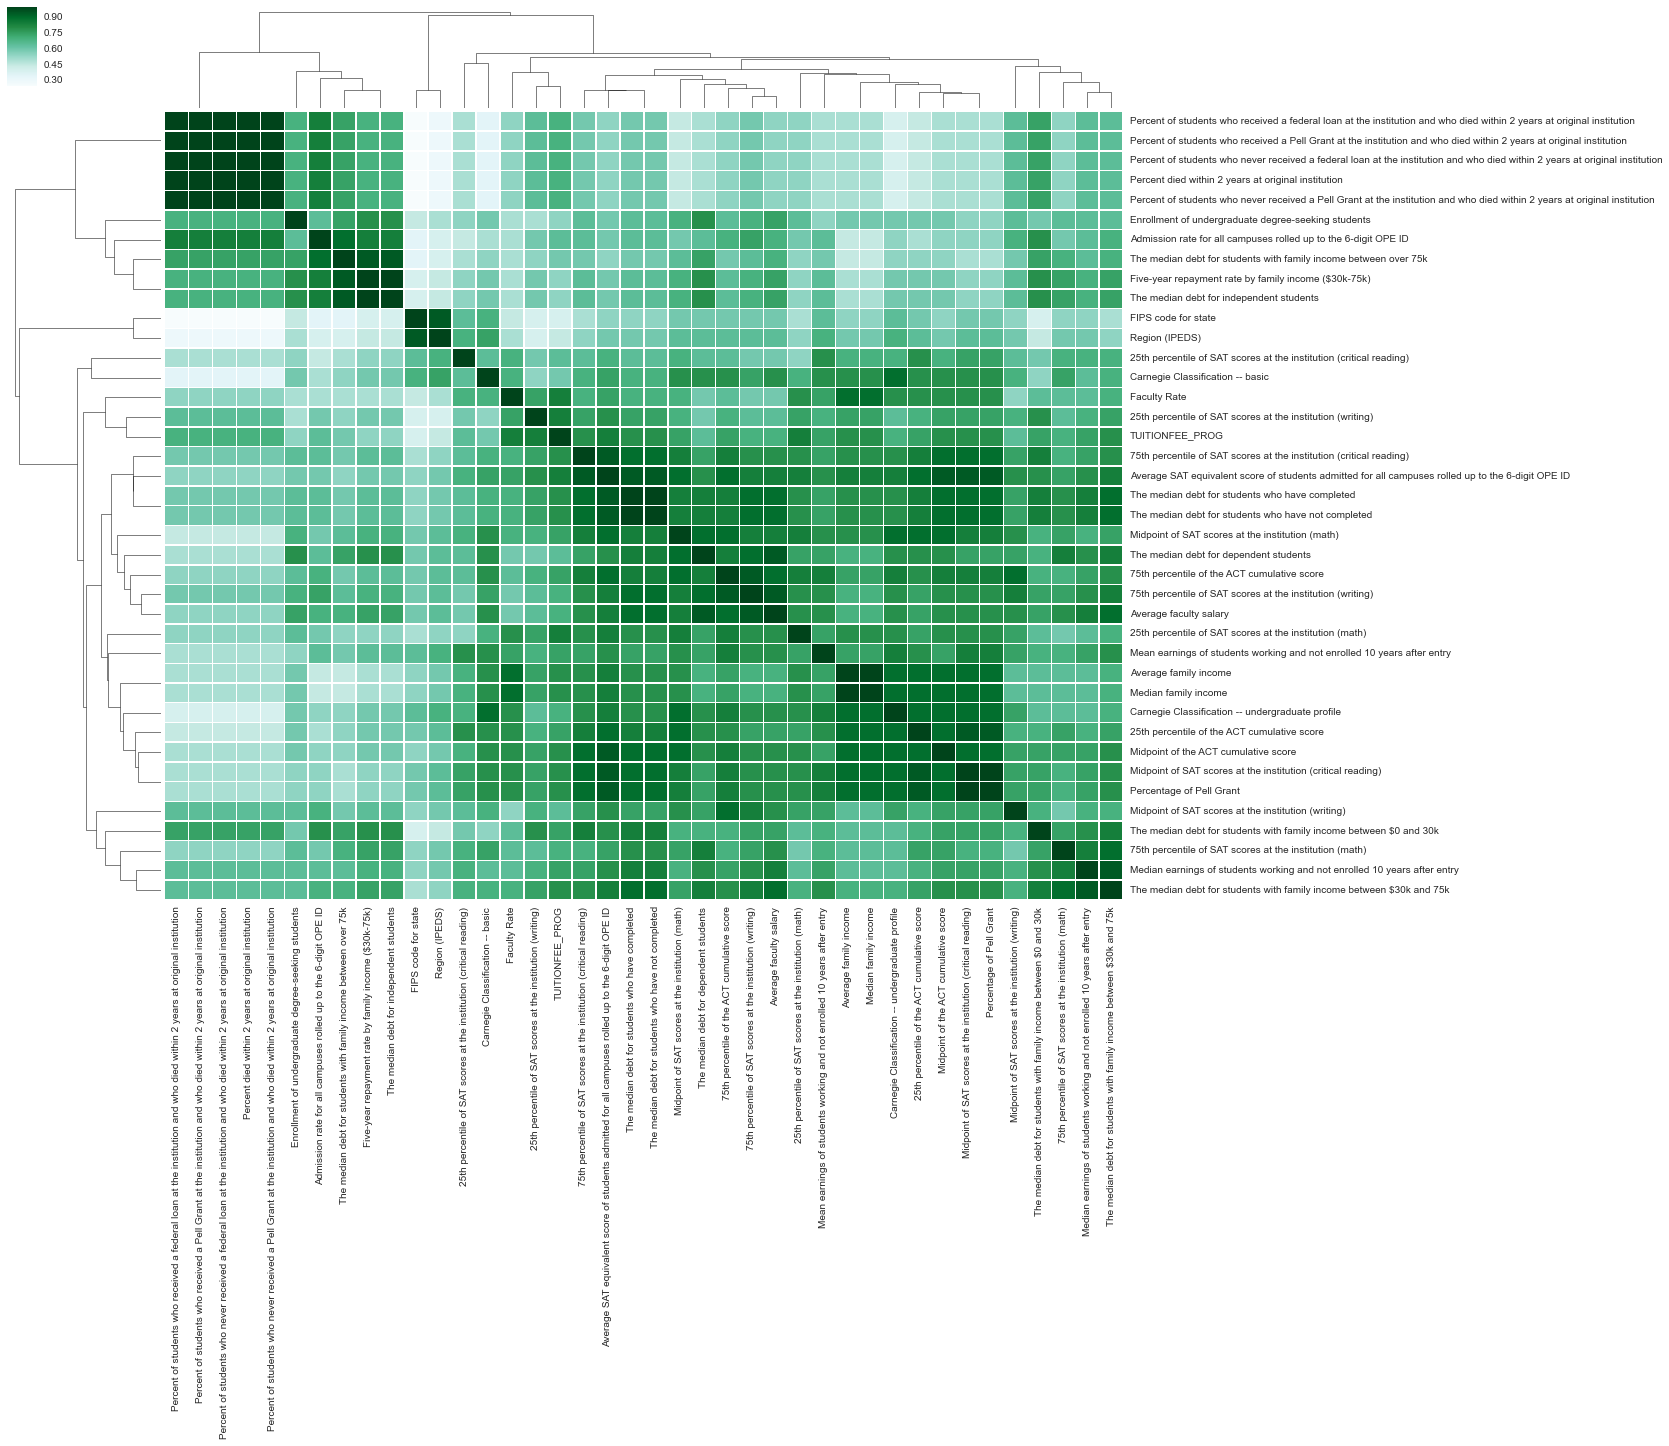

In [32]:
ed100.heatmap(ed100.q('''ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF %g'''))

It seems to be slightly better but we still observe a raw heatmap with no real conclusions to draw...<br>
Let's add some more observations

We'll check further dependencies on this latest variable (Carnegie Classification) to bring a logical explanation to this result

###We now analyze a dataset of 1000 rows

In [34]:
edx = quickstart(name='tab', bdb_path='exp.bdb') #cf Modelling notebook for name of the several dataframes
q = edx.q

BQL [SELECT COUNT(*) FROM "tab"] [()]
BQL [
        CREATE GENERATOR "tab_cc" IF NOT EXISTS FOR "tab" USING crosscat( GUESS(*) )] [()]


In [4]:
bdb = bayeslite.bayesdb_open("exp.bdb")

For this study, we are going to use metrics from 1000 schools

In [8]:
q('''select count(*) from tab''').transpose()

BQL [select count(*) from tab] [()]


,0
"""count""(*)",1000


<p style="font-family: Verdana; ">We can begin with exploring dependence relationships between variables to test out the models.<br>
One way to do that is, given the the models generated by CrossCat, and the iterations on these models invoked by our analysis, "counting" how many times two variables are in the same view of each model. In other words, the dependence relationship analysis will quantify the number of views generated by CrossCat including two pairwise columns</p>

<p style="font-family: Verdana; ">For readability purposes, the Python client for bayeslite makes it straightforward to examine the overall matrix of pairwise dependence probabilities. Cell (i,j) in this matrix records Pr[ variable i is dependent on variable j ]. The matrix is reordered using a clustering algorithm to make higher-order predictive relationships — cases where some group of variables are probably all mutually independent — more visually apparent.</p>

<b>Reminder</b>: we analyzed 16 models with 10 iterations at this point

BQL [ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF "tab_cc"] [()]


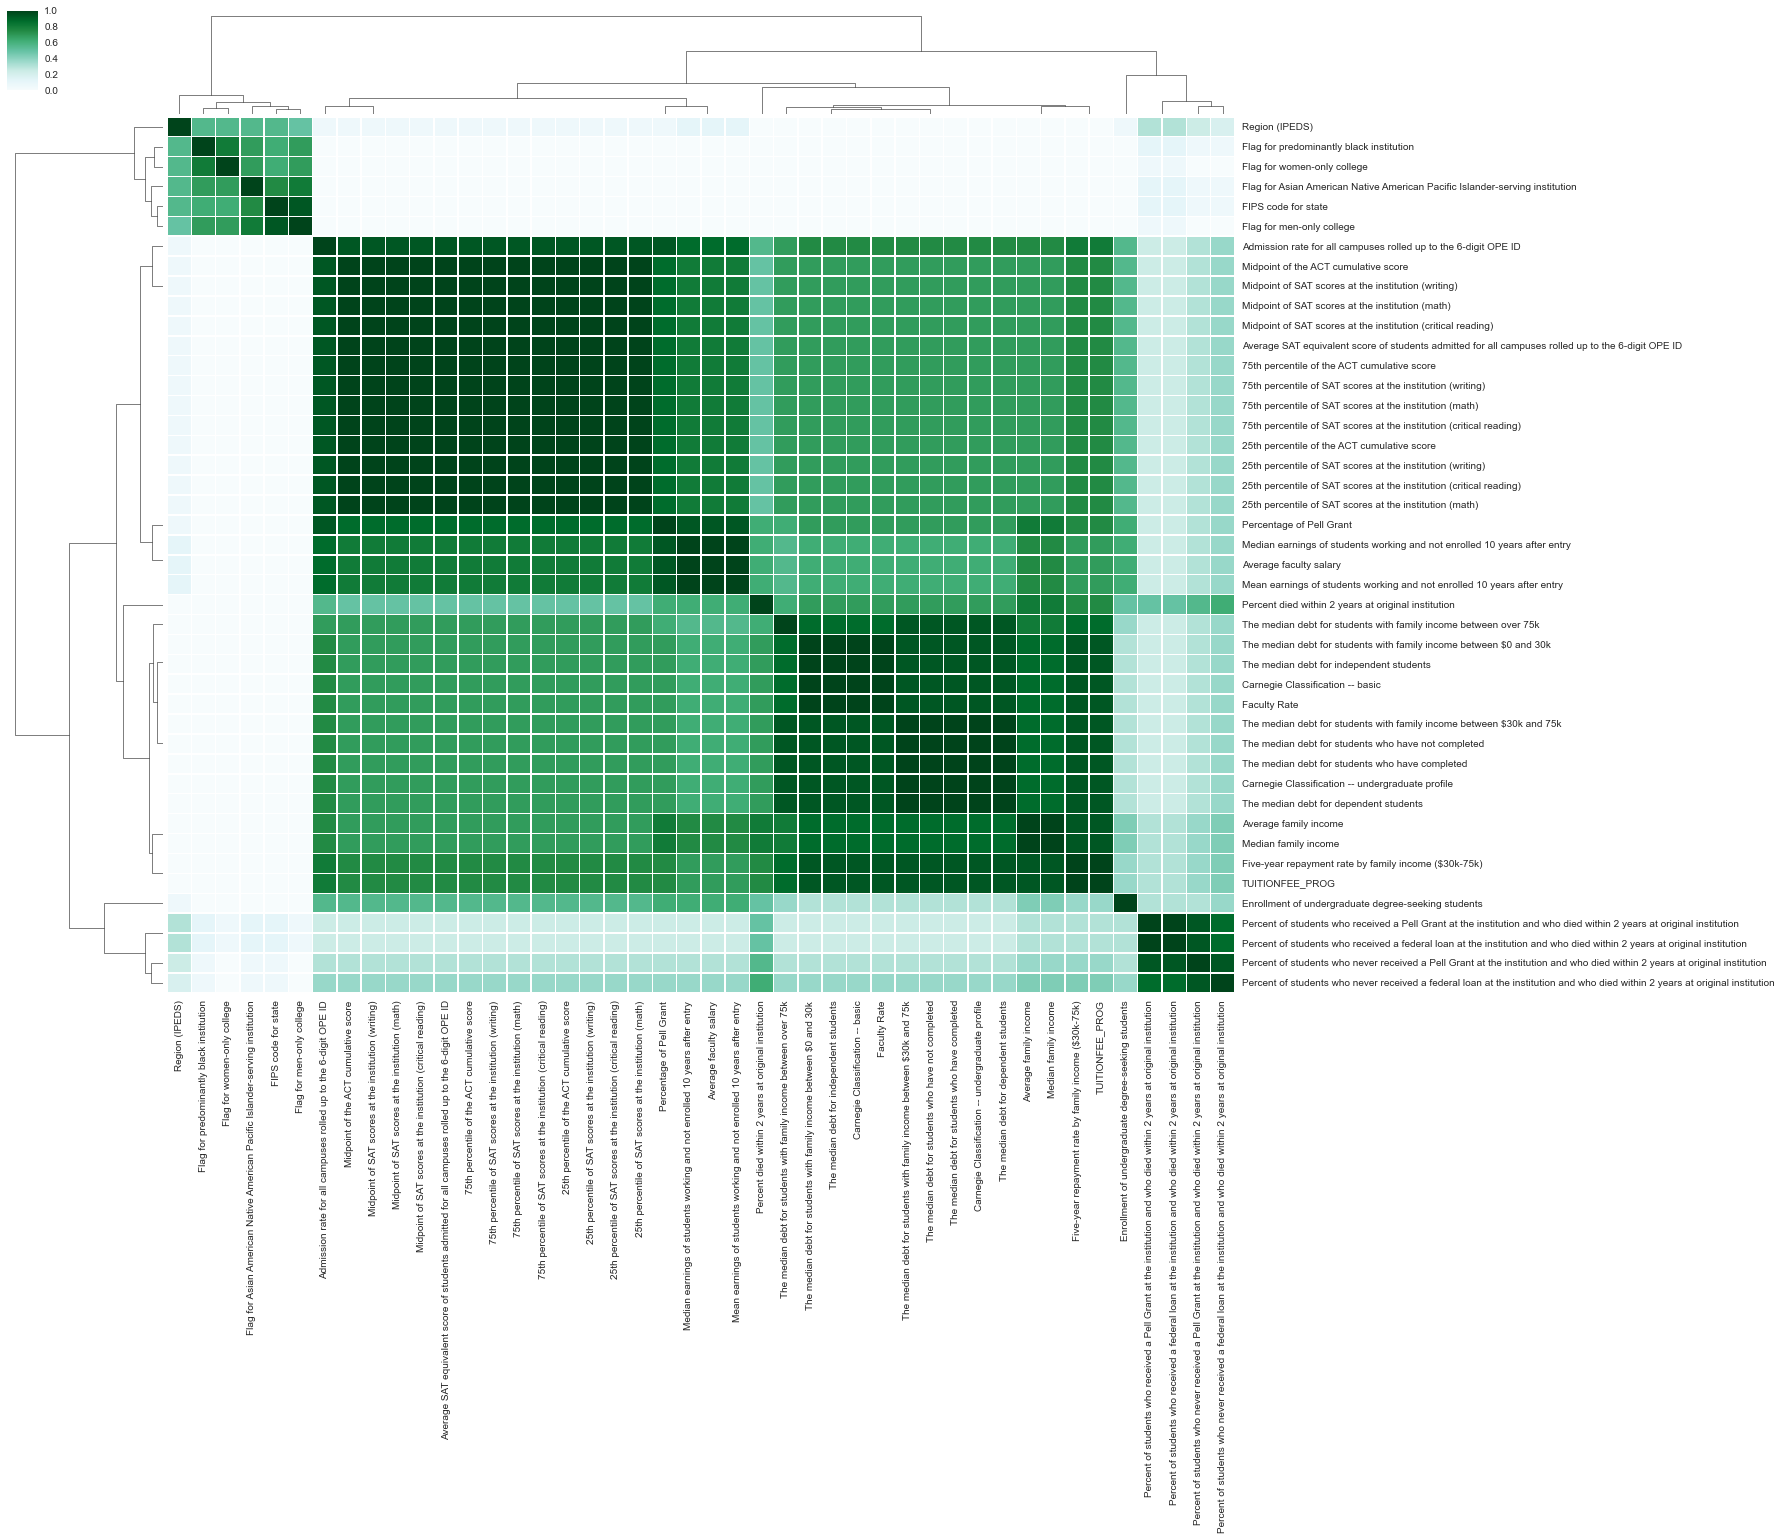

In [9]:
edx.heatmap(edx.q('''ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF %g'''))

There is a component block that can can be interesting to study in more detail. The one that shows relationship between Median family income, Mean earnings for students workings and not enrolled after 10 years of graduation and Median earnings for students workings and not enrolled after 10 years of graduation

Also, our former dependent block of four variables (reminder: Percentage of Pell Grant, Median family income, Average family income and Carnegie Classification) seems to have exploded since now the Median and Average family income are connected, together obviously, and to the Tuition fee of the school. Which makes totally sense: the richer the family the higher fee the student can afford to pay.<br>
As far as Percentage of Pell Grant, it seems that the variable joined another block composed of Median earnings of students, Mean earnings of students and average faculty salary. The dependence between those variables and Pell Grant attribution seems strange. Let's check out if the number of missing values for this variable is large or not. If yes it could be the source of these strange relations.

In [39]:
q('''select count("Percentage of Pell Grant") from tab''')

BQL [select count("Percentage of Pell Grant") from tab] [()]


,"""count""(""Percentage of Pell Grant"")"
0,846


It seems like we have 84% of valid values. We'll check later if we notice differences for this metric

BQL [ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF "tab_cc"] [()]


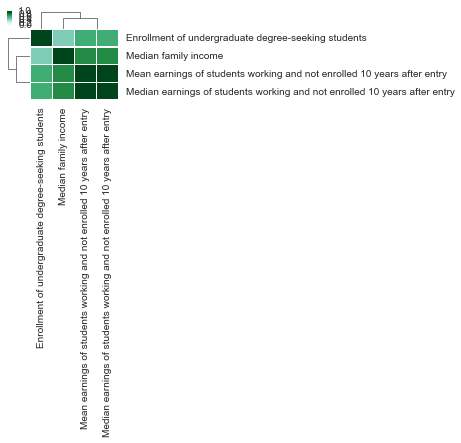

In [10]:
edx.heatmap(edx.q('''ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF %g'''), 
                 selectors={'MCAS': lambda name: 
                            "Median family income" in name 
                            or "Mean earnings of students working and not enrolled 10 years after entry" in name 
                            or "Median earnings of students working and not enrolled 10 years after entry" in name 
                            or "Enrollment of undergraduate degree-seeking students" in name                           })

One can guess that the dependance is quite against commonsense since there is no reason for the number of undergraduate student to be related to the average income of the family and to the future earnings of the student after graduation. The dependance between the mean and the median of the earnings is quite straight forward

Let's do more iterations (always with the same number of models) and see if those dependances disappear

In [11]:
edx.analyze(models = 4, iterations = 20)

BQL [INITIALIZE 4 MODELS IF NOT EXISTS FOR tab_cc] [()]
BQL [ANALYZE tab_cc FOR 20 ITERATIONS CHECKPOINT 1 ITERATION WAIT] [()]
BQL [SELECT iterations FROM bayesdb_generator_model
                           WHERE generator_id = (
                            SELECT id FROM bayesdb_generator WHERE name = ?)] [('tab_cc',)]


,count of models
iterations,
30,16


BQL [ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF "tab_cc"] [()]


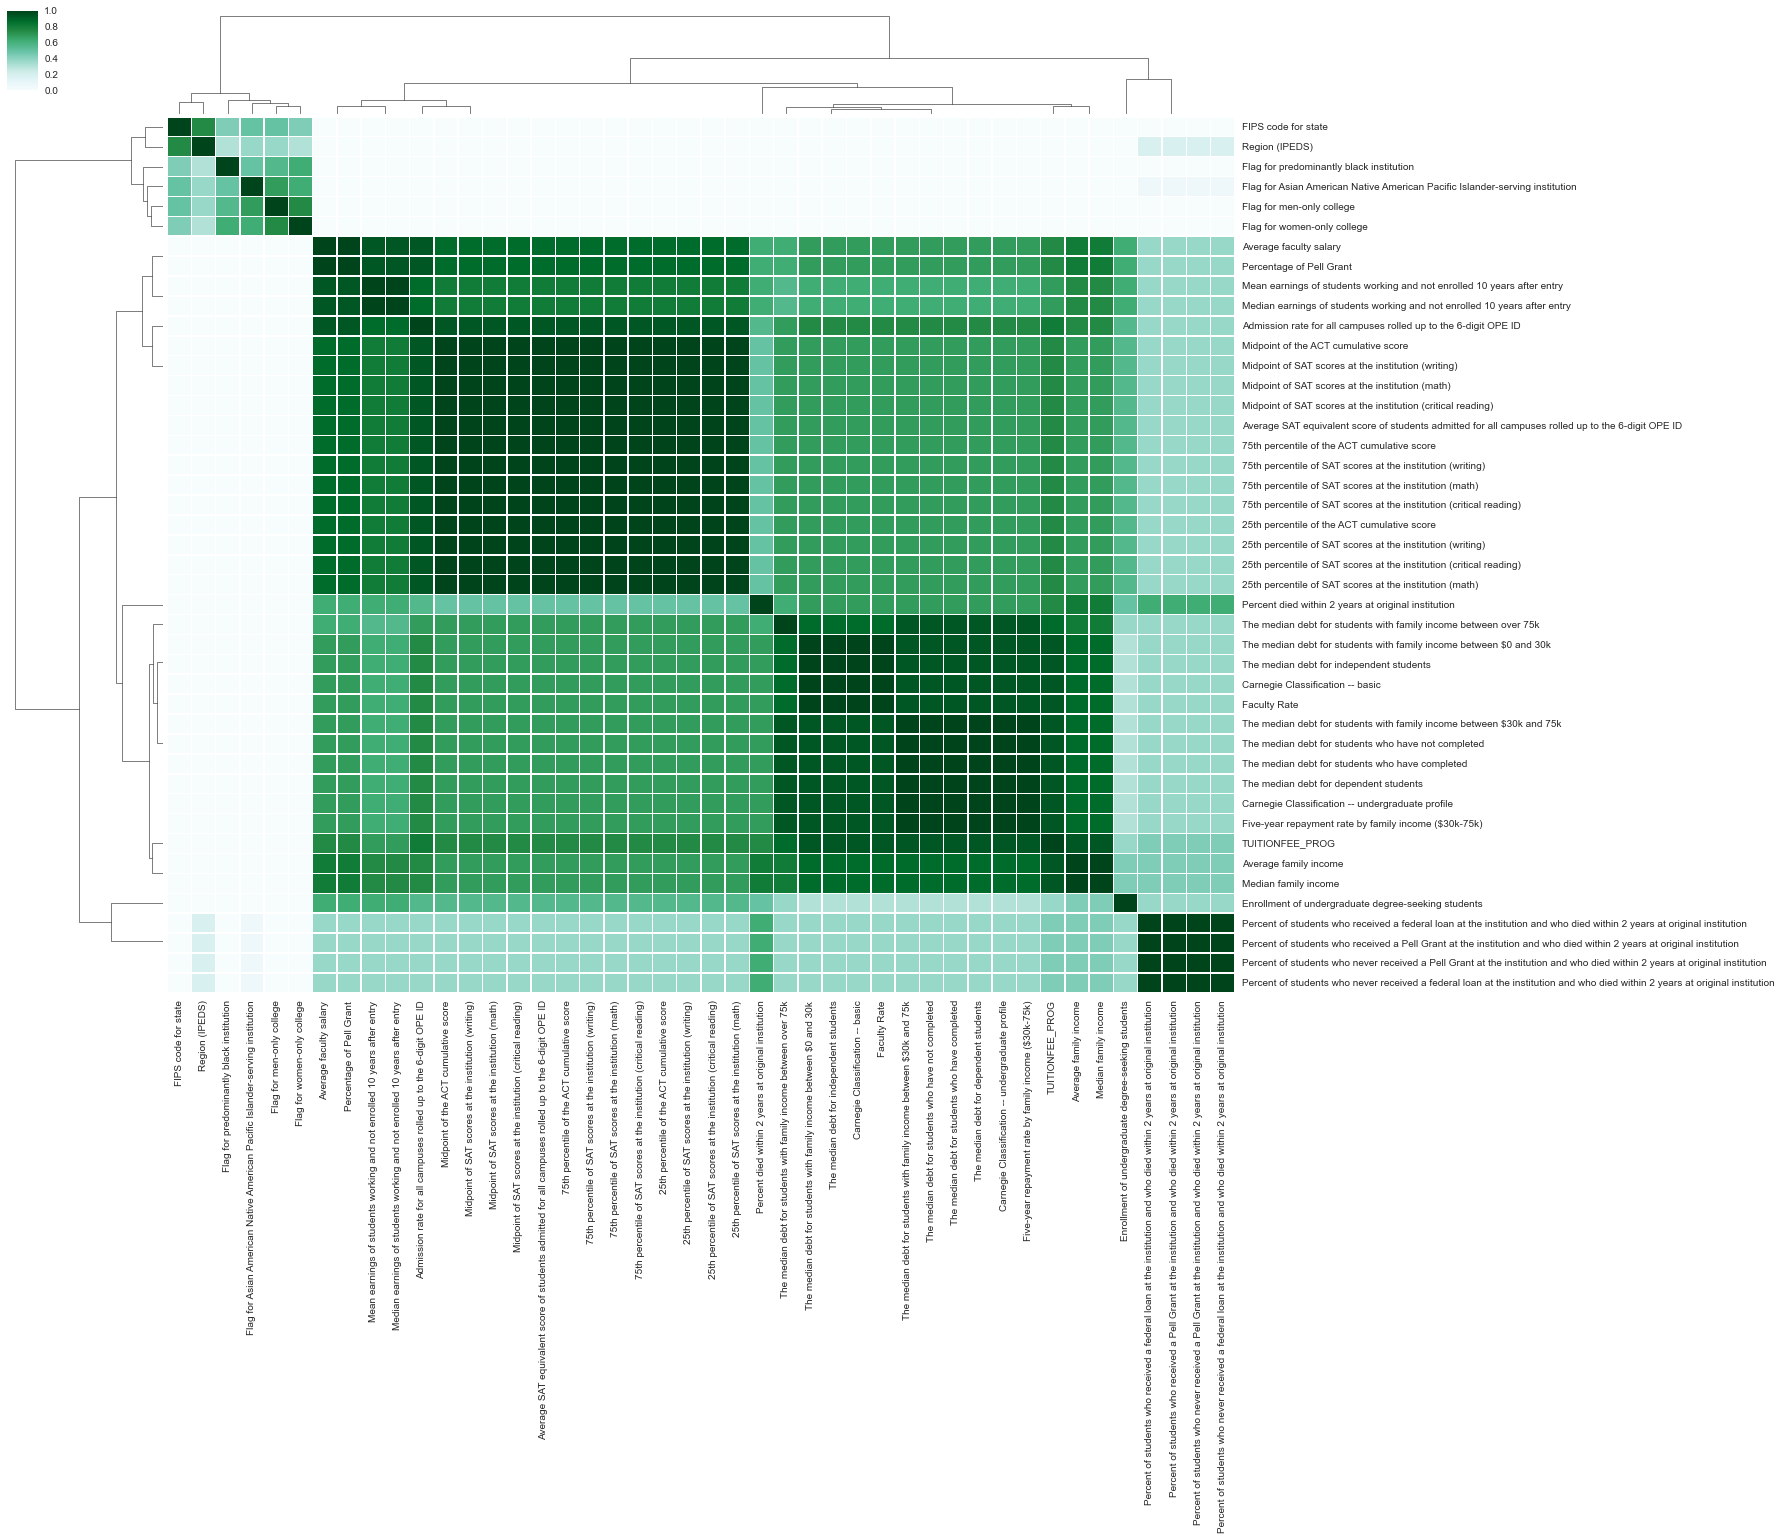

In [12]:
edx.heatmap(edx.q('''ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF %g'''))

BQL [ESTIMATE CORRELATION FROM PAIRWISE COLUMNS OF "tab_cc"] [()]


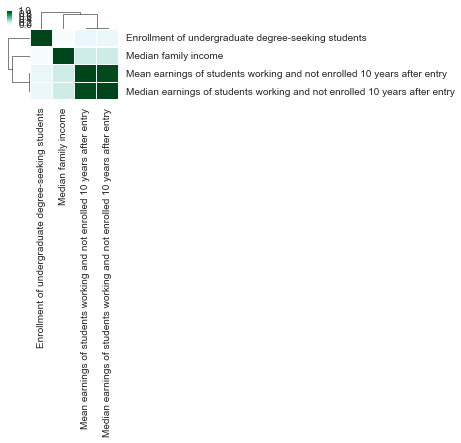

In [20]:
edx.heatmap(edx.q('''ESTIMATE CORRELATION FROM PAIRWISE COLUMNS OF %g'''), 
                 selectors={'MCAS': lambda name: 
                            "Median family income" in name 
                            or "Mean earnings of students working and not enrolled 10 years after entry" in name 
                            or "Median earnings of students working and not enrolled 10 years after entry" in name 
                            or "Enrollment of undergraduate degree-seeking students" in name                           })

Here after 20 more iterations, we can observe that the dependance between the family income and the earnings of the students after 10 years got weaker, which follow our initial intuition

Let's do more iterations (always with the same number of models)

In [15]:
edx.analyze(models = 4, iterations = 20)

BQL [INITIALIZE 4 MODELS IF NOT EXISTS FOR tab_cc] [()]
BQL [ANALYZE tab_cc FOR 20 ITERATIONS CHECKPOINT 1 ITERATION WAIT] [()]
BQL [SELECT iterations FROM bayesdb_generator_model
                           WHERE generator_id = (
                            SELECT id FROM bayesdb_generator WHERE name = ?)] [('tab_cc',)]


,count of models
iterations,
50,16


BQL [ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF "tab_cc"] [()]


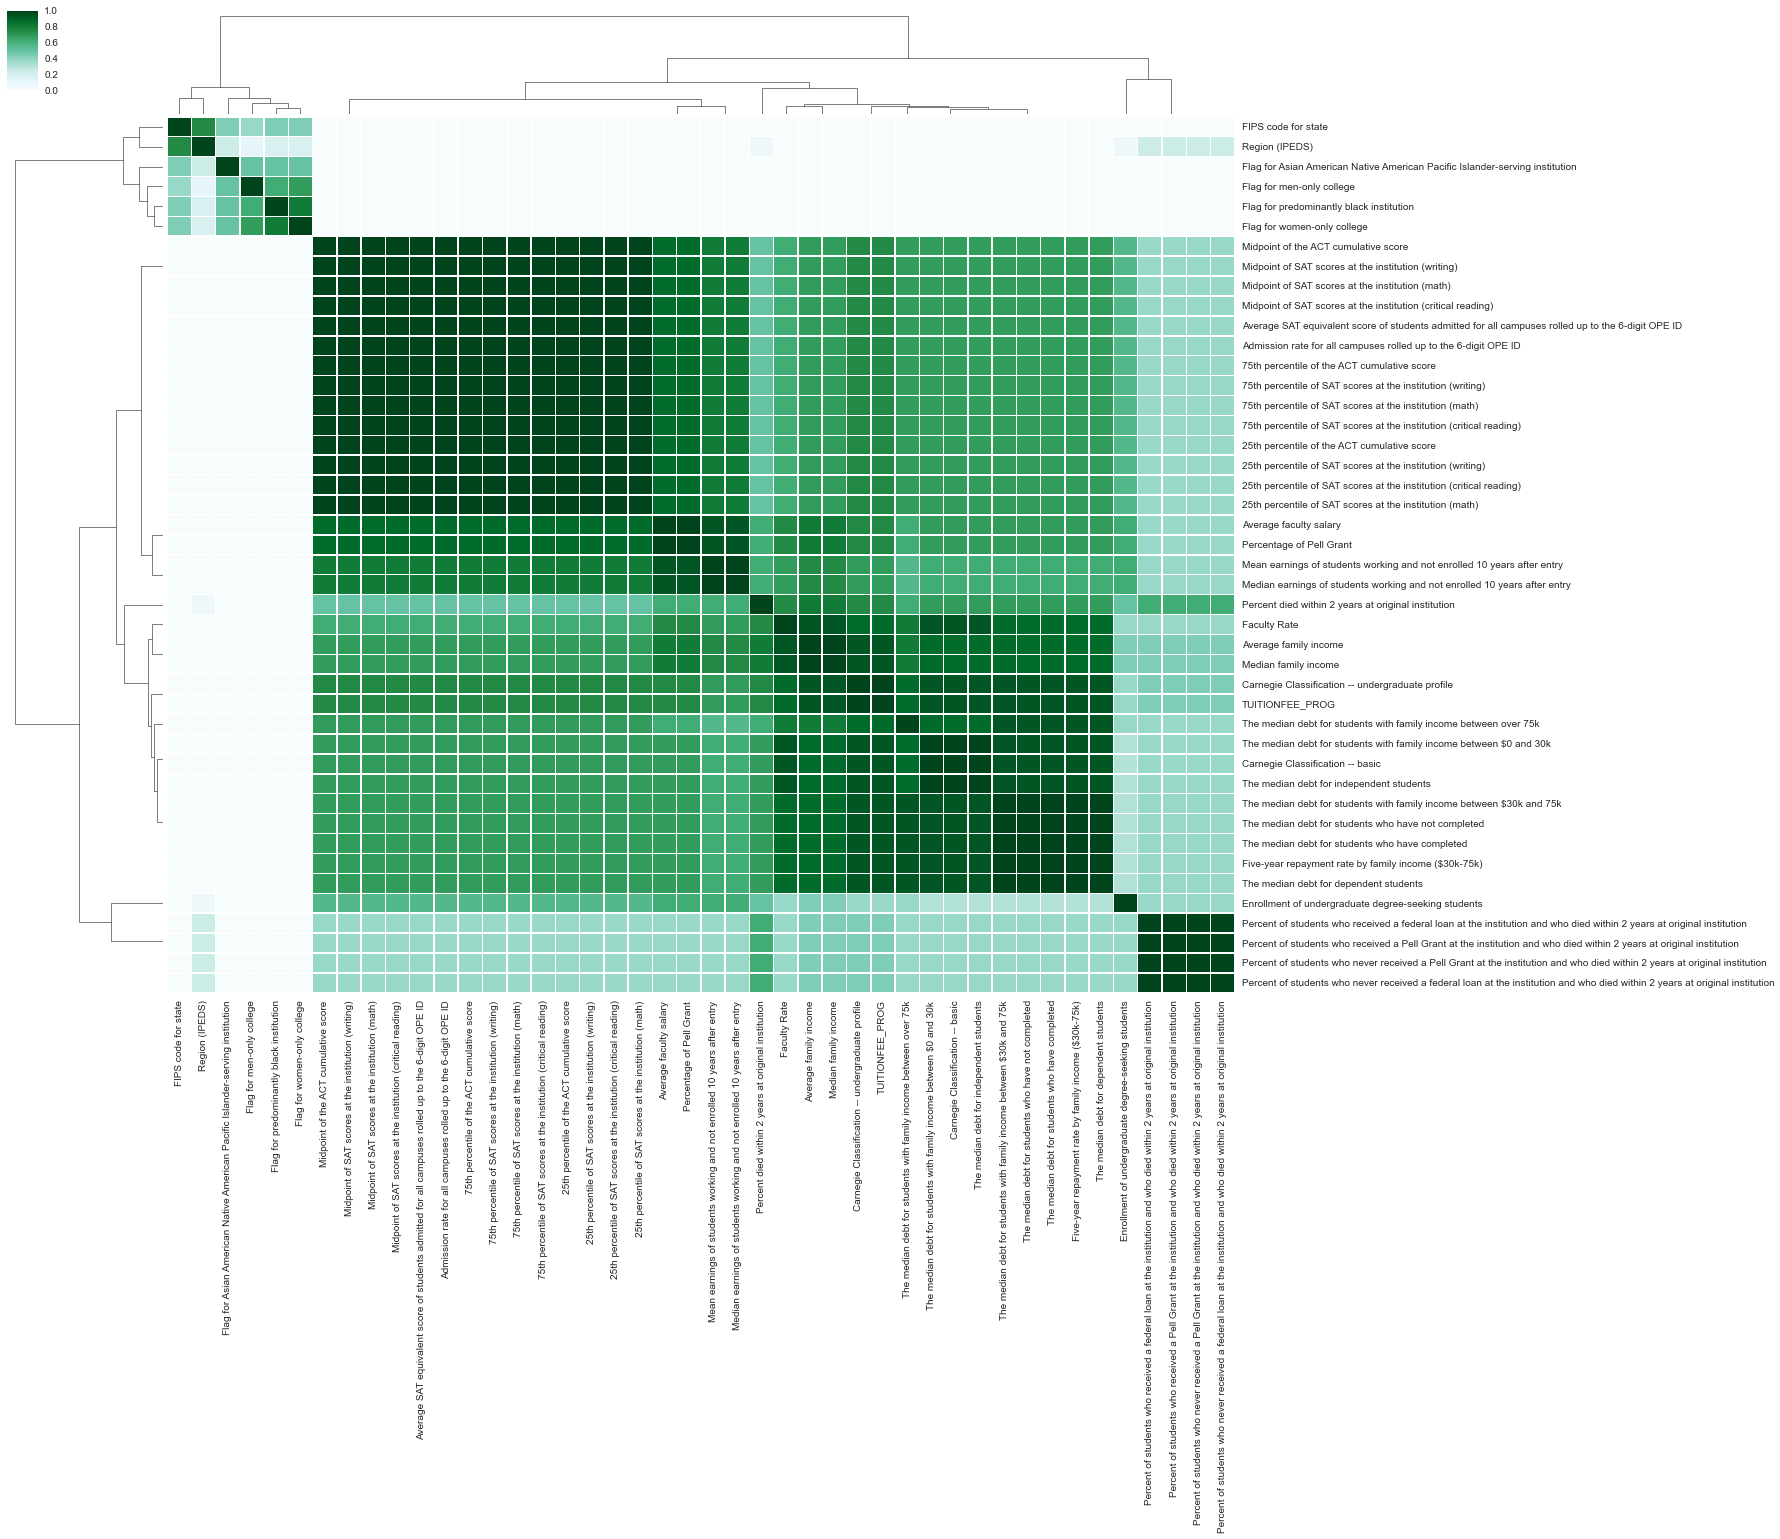

In [16]:
edx.heatmap(edx.q('''ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF %g'''))

###Let's add more rows and take 3000 universities in the US

In [18]:
import pandas as pd
import crosscat
from bdbcontrib.recipes import quickstart
import bayeslite
from bayeslite.read_pandas import bayesdb_read_pandas_df
DATA = pd.read_csv("Most+Recent+Cohorts+(All+Data+Elements).csv", delimiter=',', low_memory = False)
dfa =DATA.loc[:,['PFTFAC','UGDS','CCUGPROF','CCBASIC','locale2','region','st_fips','ACTCM75','ACTCMMID','ACTCM25','SAT_AVG_ALL','SATWR75','SATWRMID','SATWR25','SATMT75','SATMTMID','SATMT25','SATVR75','SATVRMID','SATVR25','ADM_RATE_ALL','WOMENONLY','MENONLY','AANAPII','PBI','md_earn_wne_p10','mn_earn_wne_p10','md_faminc','faminc','TUITIONFEE_PROG','AVGFACSAL','PCTPELL','IND_DEBT_MDN','HI_INC_DEBT_MDN','MD_INC_DEBT_MDN','LO_INC_DEBT_MDN','WDRAW_DEBT_MDN','GRAD_DEBT_MDN','MD_INC_RPY_5YR_RT','NOLOAN_COMP_ORIG_YR2','LOAN_COMP_ORIG_YR2','NOPELL_COMP_ORIG_YR2','PELL_COMP_ORIG_YR2','HI_INC_COMP_ORIG_Y','MD_INC_COMP_ORIG_Y','LO_INC_COMP_ORIG_Y','DEATH_YR2_RT','NOLOAN_ENRL_ORIG_YR','NOLOAN_DEATH_YR2_RT','LOAN_DEATH_YR2_RT','NOPELL_DEATH_YR2_RT','PELL_DEATH_YR2_RT','HI_INC_DEATH_YR2_R','MD_INC_DEATH_YR2_R','LO_INC_DEATH_YR2_R','DEP_DEBT_MDN']] 
dfa.columns = ['Faculty Rate','Enrollment of undergraduate degree-seeking students','Carnegie Classification -- undergraduate profile','Carnegie Classification -- basic','Degree of urbanization of institution','Region (IPEDS)','FIPS code for state','75th percentile of the ACT cumulative score','Midpoint of the ACT cumulative score','25th percentile of the ACT cumulative score','Average SAT equivalent score of students admitted for all campuses rolled up to the 6-digit OPE ID','75th percentile of SAT scores at the institution (writing)','Midpoint of SAT scores at the institution (writing)','25th percentile of SAT scores at the institution (writing)','75th percentile of SAT scores at the institution (math)','Midpoint of SAT scores at the institution (math)','25th percentile of SAT scores at the institution (math)','75th percentile of SAT scores at the institution (critical reading)','Midpoint of SAT scores at the institution (critical reading)','25th percentile of SAT scores at the institution (critical reading)','Admission rate for all campuses rolled up to the 6-digit OPE ID','Flag for women-only college','Flag for men-only college','Flag for Asian American Native American Pacific Islander-serving institution','Flag for predominantly black institution','Median earnings of students working and not enrolled 10 years after entry','Mean earnings of students working and not enrolled 10 years after entry','Median family income','Average family income','TUITIONFEE_PROG','Average faculty salary','Percentage of Pell Grant','The median debt for independent students','The median debt for students with family income between over 75k','The median debt for students with family income between $30k and 75k','The median debt for students with family income between $0 and 30k','The median debt for students who have not completed','The median debt for students who have completed','Five-year repayment rate by family income ($30k-75k)','Percent of students who never received a federal loan at the institution and who were still enrolled at original institution within 2 years','Percent of students who received a federal loan at the institution and who completed in 2 years ','Percent of students who did not receive a Pell Grant at the institution and who completed in 2 years at original ','Percent of students who received a Pell Grant at the institution and who completed in 2 years at original ','Percent of high-income (over in nominal family income) students who died within a year','Percent of middle-income (between $30k and 75k in nominal family income) students who died within a year','Percent of female students who transferred to a 2-year institution and whose status is unknown within 8 years','Percent died within 2 years at original institution','Percent of students who never received a federal loan at the institution and who were still enrolled at original institution within a year','Percent of students who never received a federal loan at the institution and who died within 2 years at original institution','Percent of students who received a federal loan at the institution and who died within 2 years at original institution','Percent of students who never received a Pell Grant at the institution and who died within 2 years at original institution','Percent of students who received a Pell Grant at the institution and who died within 2 years at original institution','Percent of high income (more than 75k in nominal family income) students who died within 2 years','Percent of middle-income (between $30k and 75k in nominal family income) students who died within 2 years','Percent of low income (between 0 and 30k in nominal family income) students who died within 2 years','The median debt for dependent students']
dfa = dfa.iloc[0:3000,:]
bayesdb_read_pandas_df(bdb, "tab1", dfa, create=True)

In [40]:
ed3000 = quickstart(name='tab1', bdb_path='exp.bdb')
q = ed3000.q

BQL [SELECT COUNT(*) FROM "tab1"] [()]
BQL [
        CREATE GENERATOR "tab1_cc" IF NOT EXISTS FOR "tab1" USING crosscat( GUESS(*) )] [()]


In [12]:
ed3000.analyze(models = 16, iterations = 10)

BQL [INITIALIZE 16 MODELS IF NOT EXISTS FOR tab1_cc] [()]
BQL [ANALYZE tab1_cc FOR 10 ITERATIONS CHECKPOINT 1 ITERATION WAIT] [()]
BQL [SELECT iterations FROM bayesdb_generator_model
                           WHERE generator_id = (
                            SELECT id FROM bayesdb_generator WHERE name = ?)] [('tab1_cc',)]


,count of models
iterations,
10,16


BQL [ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF "tab1_cc"] [()]


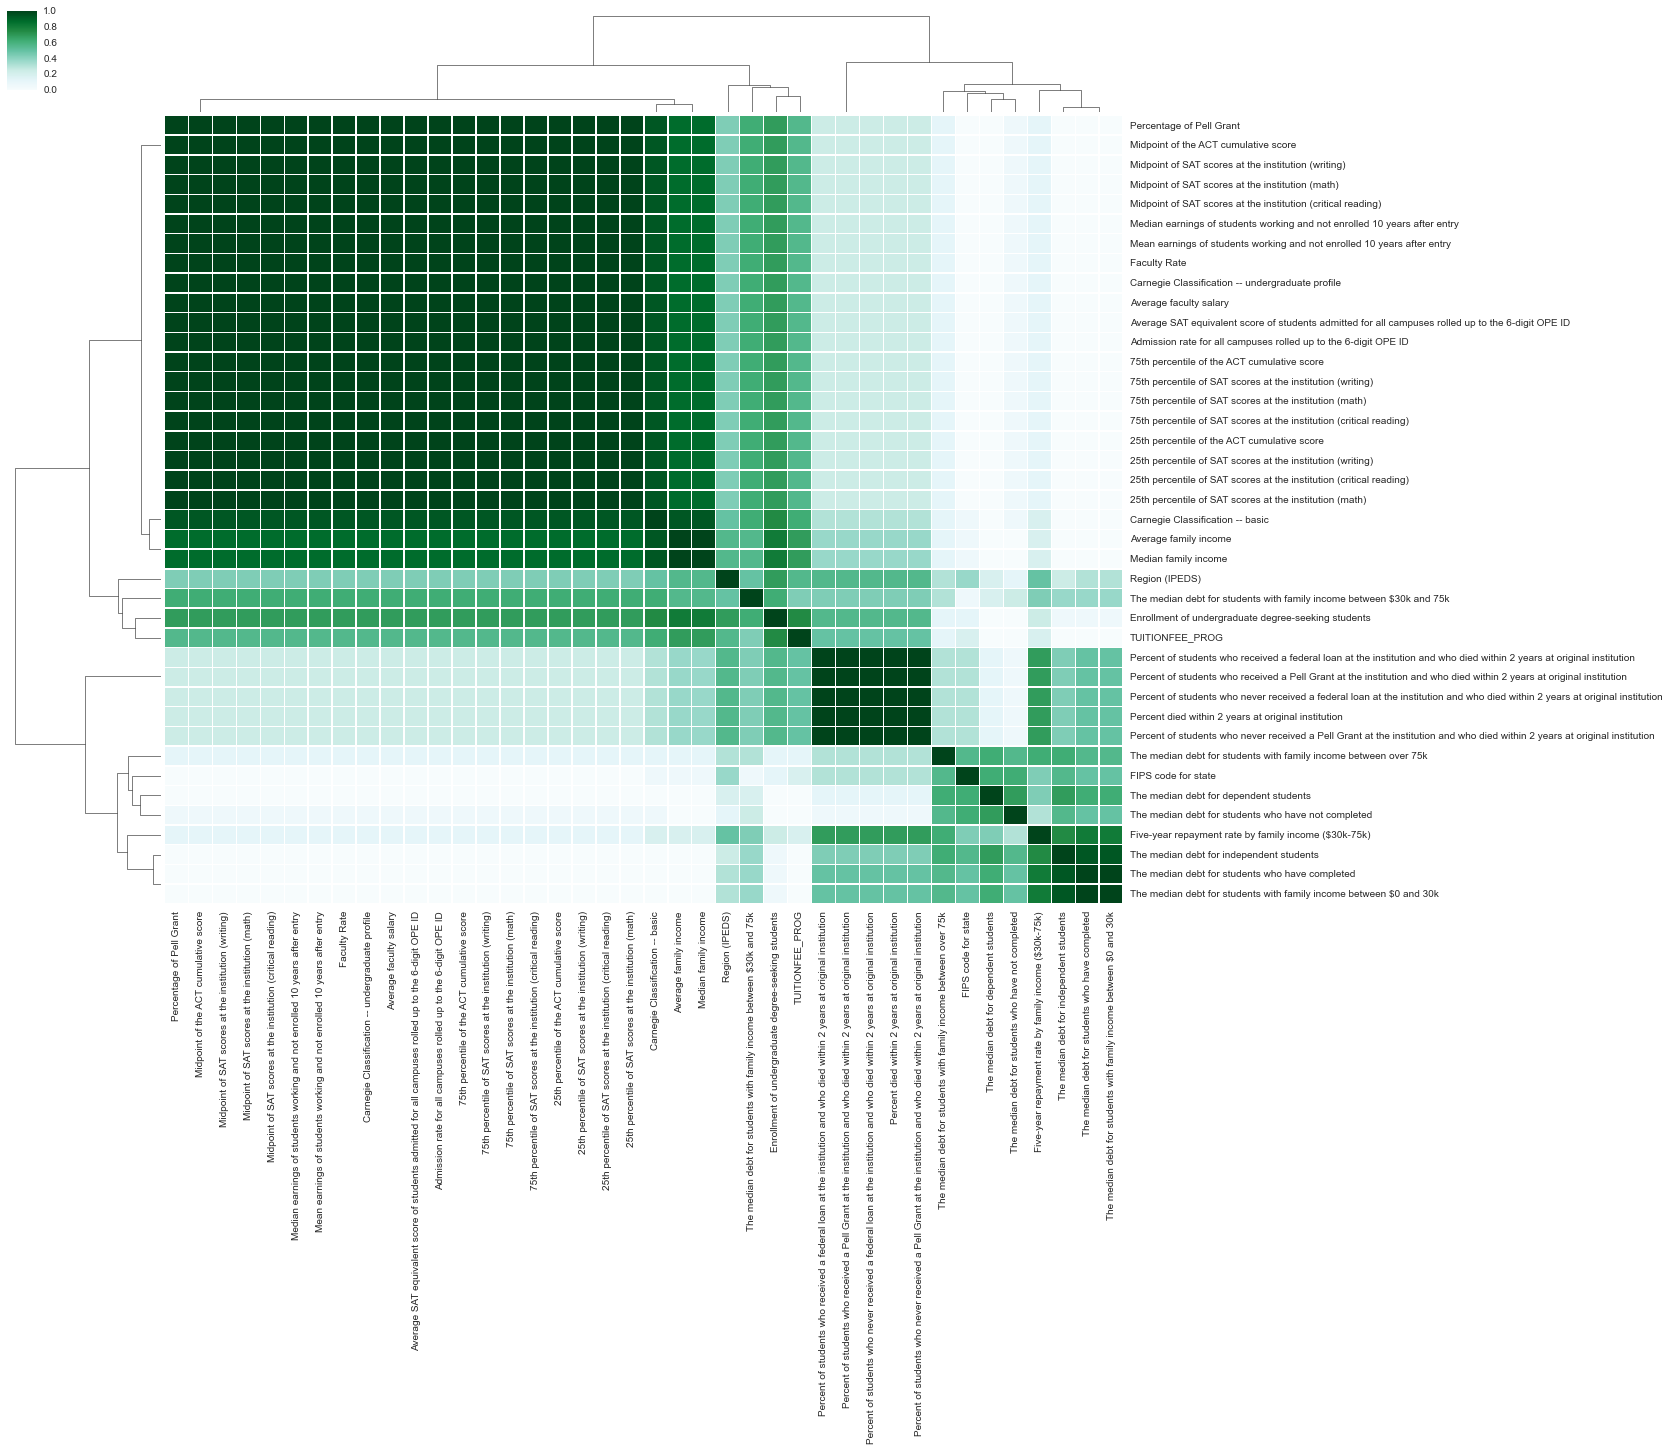

In [14]:
ed3000.heatmap(ed3000.q('''ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF %g'''))

We have exactly the same heatmap since we've added rows to the model but we did not included them in the models yet and did not analyzed them as well

Let's add 4 more models to the current 16 and do 10 more iterations on the subset of 3000 rows (since we've added 2000 rows)

In [18]:
ed3000.analyze(models=20, iterations=10)

BQL [INITIALIZE 20 MODELS IF NOT EXISTS FOR tab1_cc] [()]
BQL [ANALYZE tab1_cc FOR 10 ITERATIONS CHECKPOINT 1 ITERATION WAIT] [()]
BQL [SELECT iterations FROM bayesdb_generator_model
                           WHERE generator_id = (
                            SELECT id FROM bayesdb_generator WHERE name = ?)] [('tab1_cc',)]


,count of models
iterations,
20,16
10,4


BQL [ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF "tab1_cc"] [()]


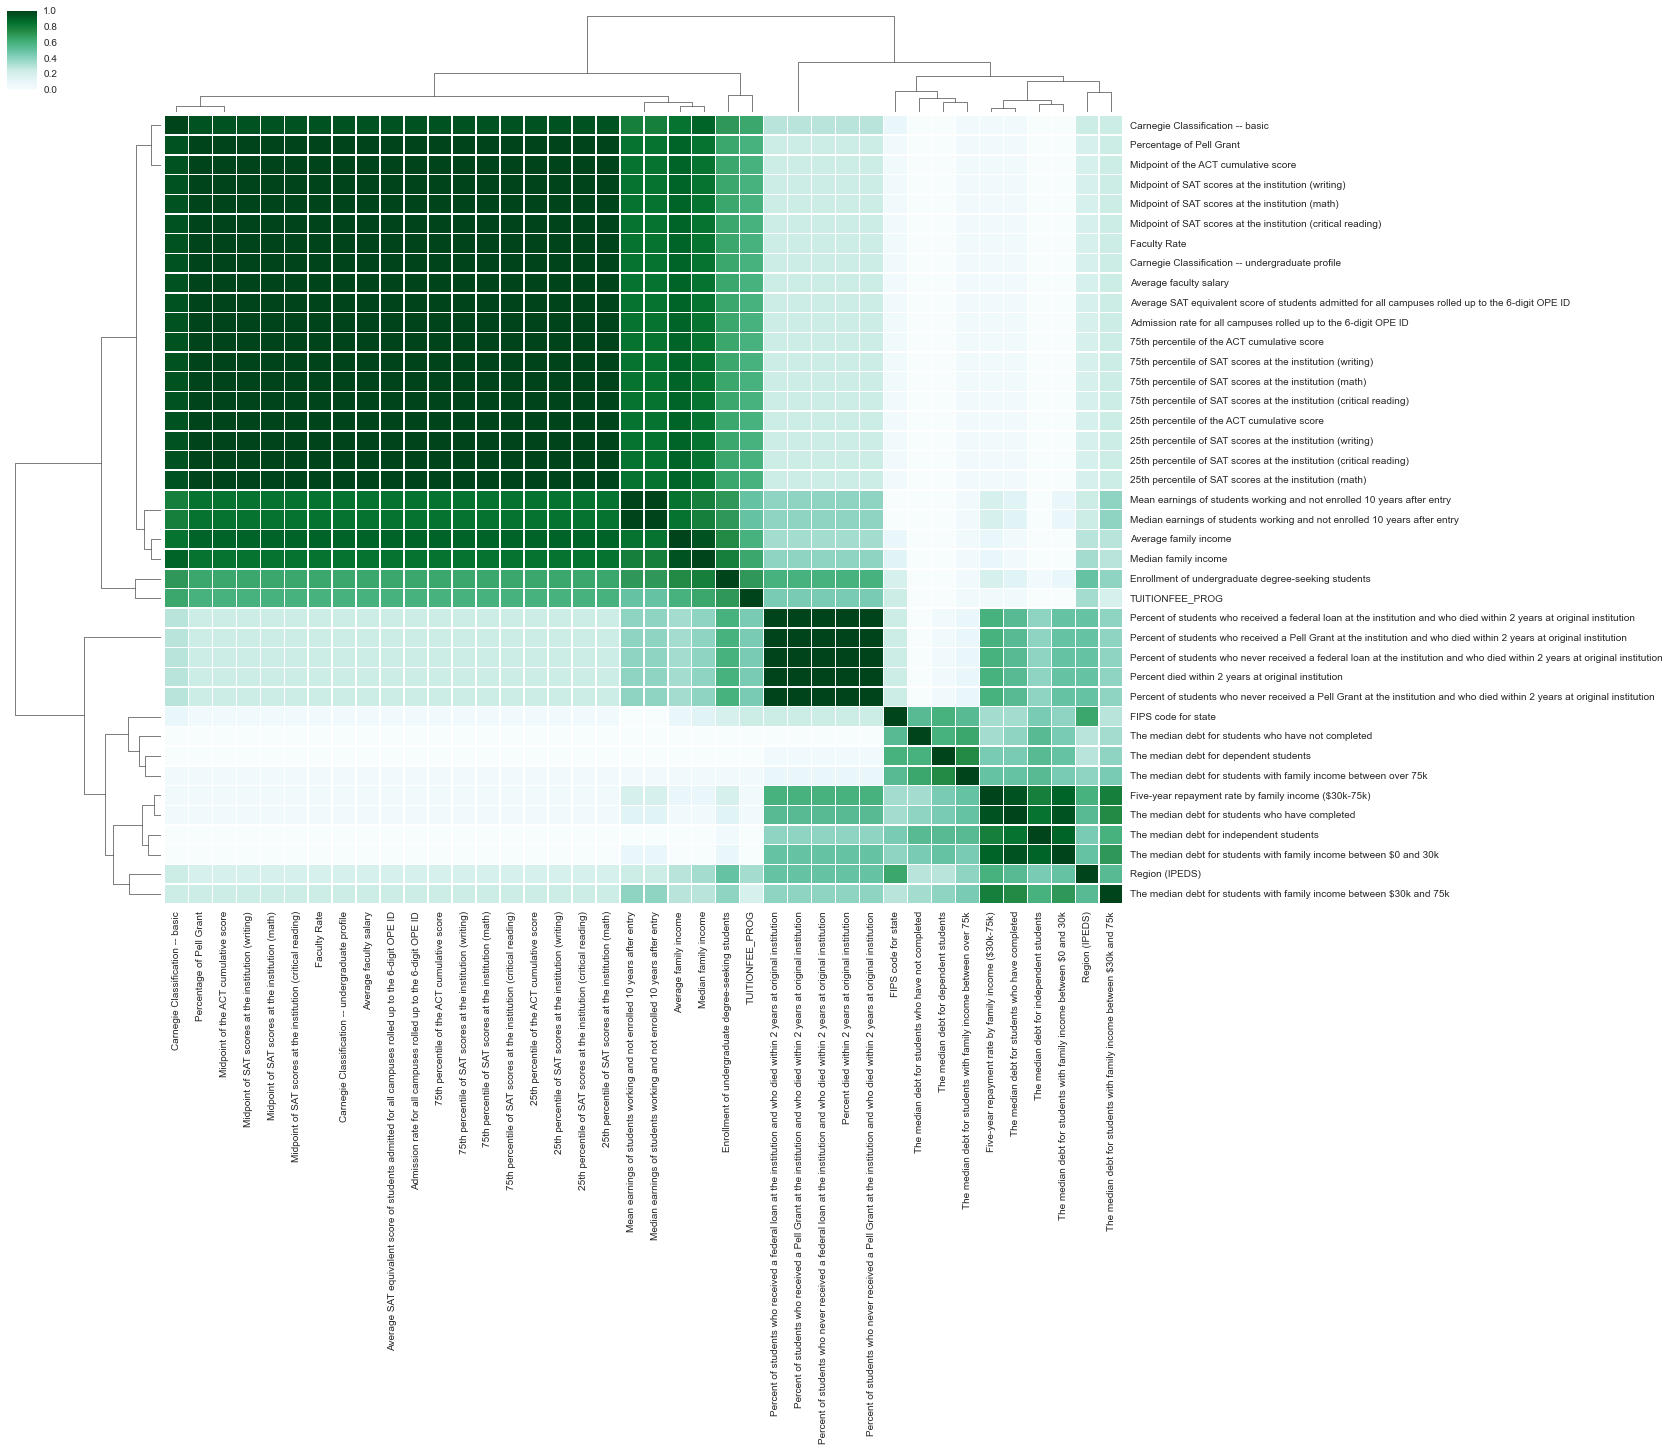

In [19]:
ed3000.heatmap(ed3000.q('''ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF %g'''))

BQL [ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF "tab1_cc"] [()]


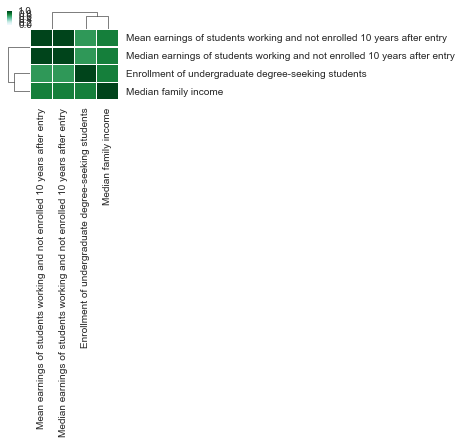

In [42]:
ed3000.heatmap(ed3000.q('''ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF %g'''), 
                 selectors={'MCAS': lambda name: 
                            "Median family income" in name 
                            or "Mean earnings of students working and not enrolled 10 years after entry" in name 
                            or "Median earnings of students working and not enrolled 10 years after entry" in name 
                            or "Enrollment of undergraduate degree-seeking students" in name                           })

It seems like we found these weird relations again even with more observations (3000 vs. 1000).<br>
But, the difference is that this heatmap has been generated after only 10 iterations on 4 new models. So one can think that the number of observations does not matter to take out intuitive dependence out of our dataset but the number of iterations and the models matter. Indeed, the fact to analyze more times with more iterations is actually serving for true dependencies between variables. Following these three analysis (first with 100 then 1000 and finally with 3000) showed us that no matter the number of observations, if you don't train your model enough time (meaning, you don't let it test dependencies for each rows and columns by moving them one by one from a view to another) it will always show you roughly the same results.<br>
We can maybe assume that the more observations you have the less models and iterations you need to do in order to take out relevant dependencies.

In [43]:
ed3000.analyze(models=24, iterations=20)

BQL [INITIALIZE 24 MODELS IF NOT EXISTS FOR tab1_cc] [()]
BQL [ANALYZE tab1_cc FOR 20 ITERATIONS CHECKPOINT 1 ITERATION WAIT] [()]
BQL [SELECT iterations FROM bayesdb_generator_model
                           WHERE generator_id = (
                            SELECT id FROM bayesdb_generator WHERE name = ?)] [('tab1_cc',)]


,count of models
iterations,
40,16
30,4
20,4


BQL [ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF "tab1_cc"] [()]


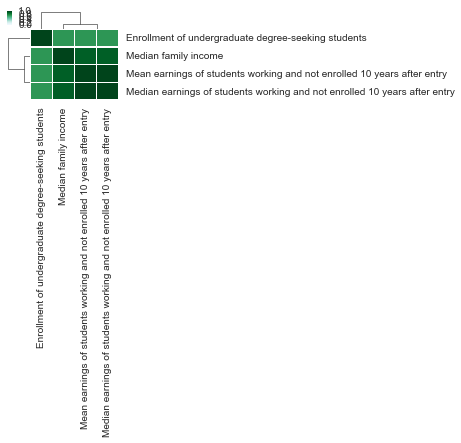

In [44]:
ed3000.heatmap(ed3000.q('''ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF %g'''), 
                 selectors={'MCAS': lambda name: 
                            "Median family income" in name 
                            or "Mean earnings of students working and not enrolled 10 years after entry" in name 
                            or "Median earnings of students working and not enrolled 10 years after entry" in name 
                            or "Enrollment of undergraduate degree-seeking students" in name                           })

###Let's now add them all (7804 rows)

In [26]:
import pandas as pd
import crosscat
from bdbcontrib.recipes import quickstart
import bayeslite
from bayeslite.read_pandas import bayesdb_read_pandas_df
DATA = pd.read_csv("Most+Recent+Cohorts+(All+Data+Elements).csv", delimiter=',', low_memory = False)
data =DATA.loc[:,['PFTFAC','UGDS','CCUGPROF','CCBASIC','locale2','region','st_fips','ACTCM75','ACTCMMID','ACTCM25','SAT_AVG_ALL','SATWR75','SATWRMID','SATWR25','SATMT75','SATMTMID','SATMT25','SATVR75','SATVRMID','SATVR25','ADM_RATE_ALL','WOMENONLY','MENONLY','AANAPII','PBI','md_earn_wne_p10','mn_earn_wne_p10','md_faminc','faminc','TUITIONFEE_PROG','AVGFACSAL','PCTPELL','IND_DEBT_MDN','HI_INC_DEBT_MDN','MD_INC_DEBT_MDN','LO_INC_DEBT_MDN','WDRAW_DEBT_MDN','GRAD_DEBT_MDN','MD_INC_RPY_5YR_RT','NOLOAN_COMP_ORIG_YR2','LOAN_COMP_ORIG_YR2','NOPELL_COMP_ORIG_YR2','PELL_COMP_ORIG_YR2','HI_INC_COMP_ORIG_Y','MD_INC_COMP_ORIG_Y','LO_INC_COMP_ORIG_Y','DEATH_YR2_RT','NOLOAN_ENRL_ORIG_YR','NOLOAN_DEATH_YR2_RT','LOAN_DEATH_YR2_RT','NOPELL_DEATH_YR2_RT','PELL_DEATH_YR2_RT','HI_INC_DEATH_YR2_R','MD_INC_DEATH_YR2_R','LO_INC_DEATH_YR2_R','DEP_DEBT_MDN']] 
data.columns = ['Faculty Rate','Enrollment of undergraduate degree-seeking students','Carnegie Classification -- undergraduate profile','Carnegie Classification -- basic','Degree of urbanization of institution','Region (IPEDS)','FIPS code for state','75th percentile of the ACT cumulative score','Midpoint of the ACT cumulative score','25th percentile of the ACT cumulative score','Average SAT equivalent score of students admitted for all campuses rolled up to the 6-digit OPE ID','75th percentile of SAT scores at the institution (writing)','Midpoint of SAT scores at the institution (writing)','25th percentile of SAT scores at the institution (writing)','75th percentile of SAT scores at the institution (math)','Midpoint of SAT scores at the institution (math)','25th percentile of SAT scores at the institution (math)','75th percentile of SAT scores at the institution (critical reading)','Midpoint of SAT scores at the institution (critical reading)','25th percentile of SAT scores at the institution (critical reading)','Admission rate for all campuses rolled up to the 6-digit OPE ID','Flag for women-only college','Flag for men-only college','Flag for Asian American Native American Pacific Islander-serving institution','Flag for predominantly black institution','Median earnings of students working and not enrolled 10 years after entry','Mean earnings of students working and not enrolled 10 years after entry','Median family income','Average family income','TUITIONFEE_PROG','Average faculty salary','Percentage of Pell Grant','The median debt for independent students','The median debt for students with family income between over 75k','The median debt for students with family income between $30k and 75k','The median debt for students with family income between $0 and 30k','The median debt for students who have not completed','The median debt for students who have completed','Five-year repayment rate by family income ($30k-75k)','Percent of students who never received a federal loan at the institution and who were still enrolled at original institution within 2 years','Percent of students who received a federal loan at the institution and who completed in 2 years ','Percent of students who did not receive a Pell Grant at the institution and who completed in 2 years at original ','Percent of students who received a Pell Grant at the institution and who completed in 2 years at original ','Percent of high-income (over in nominal family income) students who died within a year','Percent of middle-income (between $30k and 75k in nominal family income) students who died within a year','Percent of female students who transferred to a 2-year institution and whose status is unknown within 8 years','Percent died within 2 years at original institution','Percent of students who never received a federal loan at the institution and who were still enrolled at original institution within a year','Percent of students who never received a federal loan at the institution and who died within 2 years at original institution','Percent of students who received a federal loan at the institution and who died within 2 years at original institution','Percent of students who never received a Pell Grant at the institution and who died within 2 years at original institution','Percent of students who received a Pell Grant at the institution and who died within 2 years at original institution','Percent of high income (more than 75k in nominal family income) students who died within 2 years','Percent of middle-income (between $30k and 75k in nominal family income) students who died within 2 years','Percent of low income (between 0 and 30k in nominal family income) students who died within 2 years','The median debt for dependent students']
bayesdb_read_pandas_df(bdb, "taball", data, create=True)

Now we have to analyze and iterate on the new models including the new rows. We 're adding 10 more models and 10 iterations on the overall 20 models

In [15]:
ed7000 = quickstart(name='taball', bdb_path='exp.bdb')
q = edx.q

BQL [SELECT COUNT(*) FROM "taball"] [()]
BQL [
        CREATE GENERATOR "taball_cc" IF NOT EXISTS FOR "taball" USING crosscat( GUESS(*) )] [()]


In [8]:
ed7000.analyze(models = 4, iterations = 10)

BQL [INITIALIZE 4 MODELS IF NOT EXISTS FOR taball_cc] [()]
BQL [ANALYZE taball_cc FOR 10 ITERATIONS CHECKPOINT 1 ITERATION WAIT] [()]
BQL [SELECT iterations FROM bayesdb_generator_model
                           WHERE generator_id = (
                            SELECT id FROM bayesdb_generator WHERE name = ?)] [('taball_cc',)]


,count of models
iterations,
11,16


BQL [ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF "taball_cc"] [()]


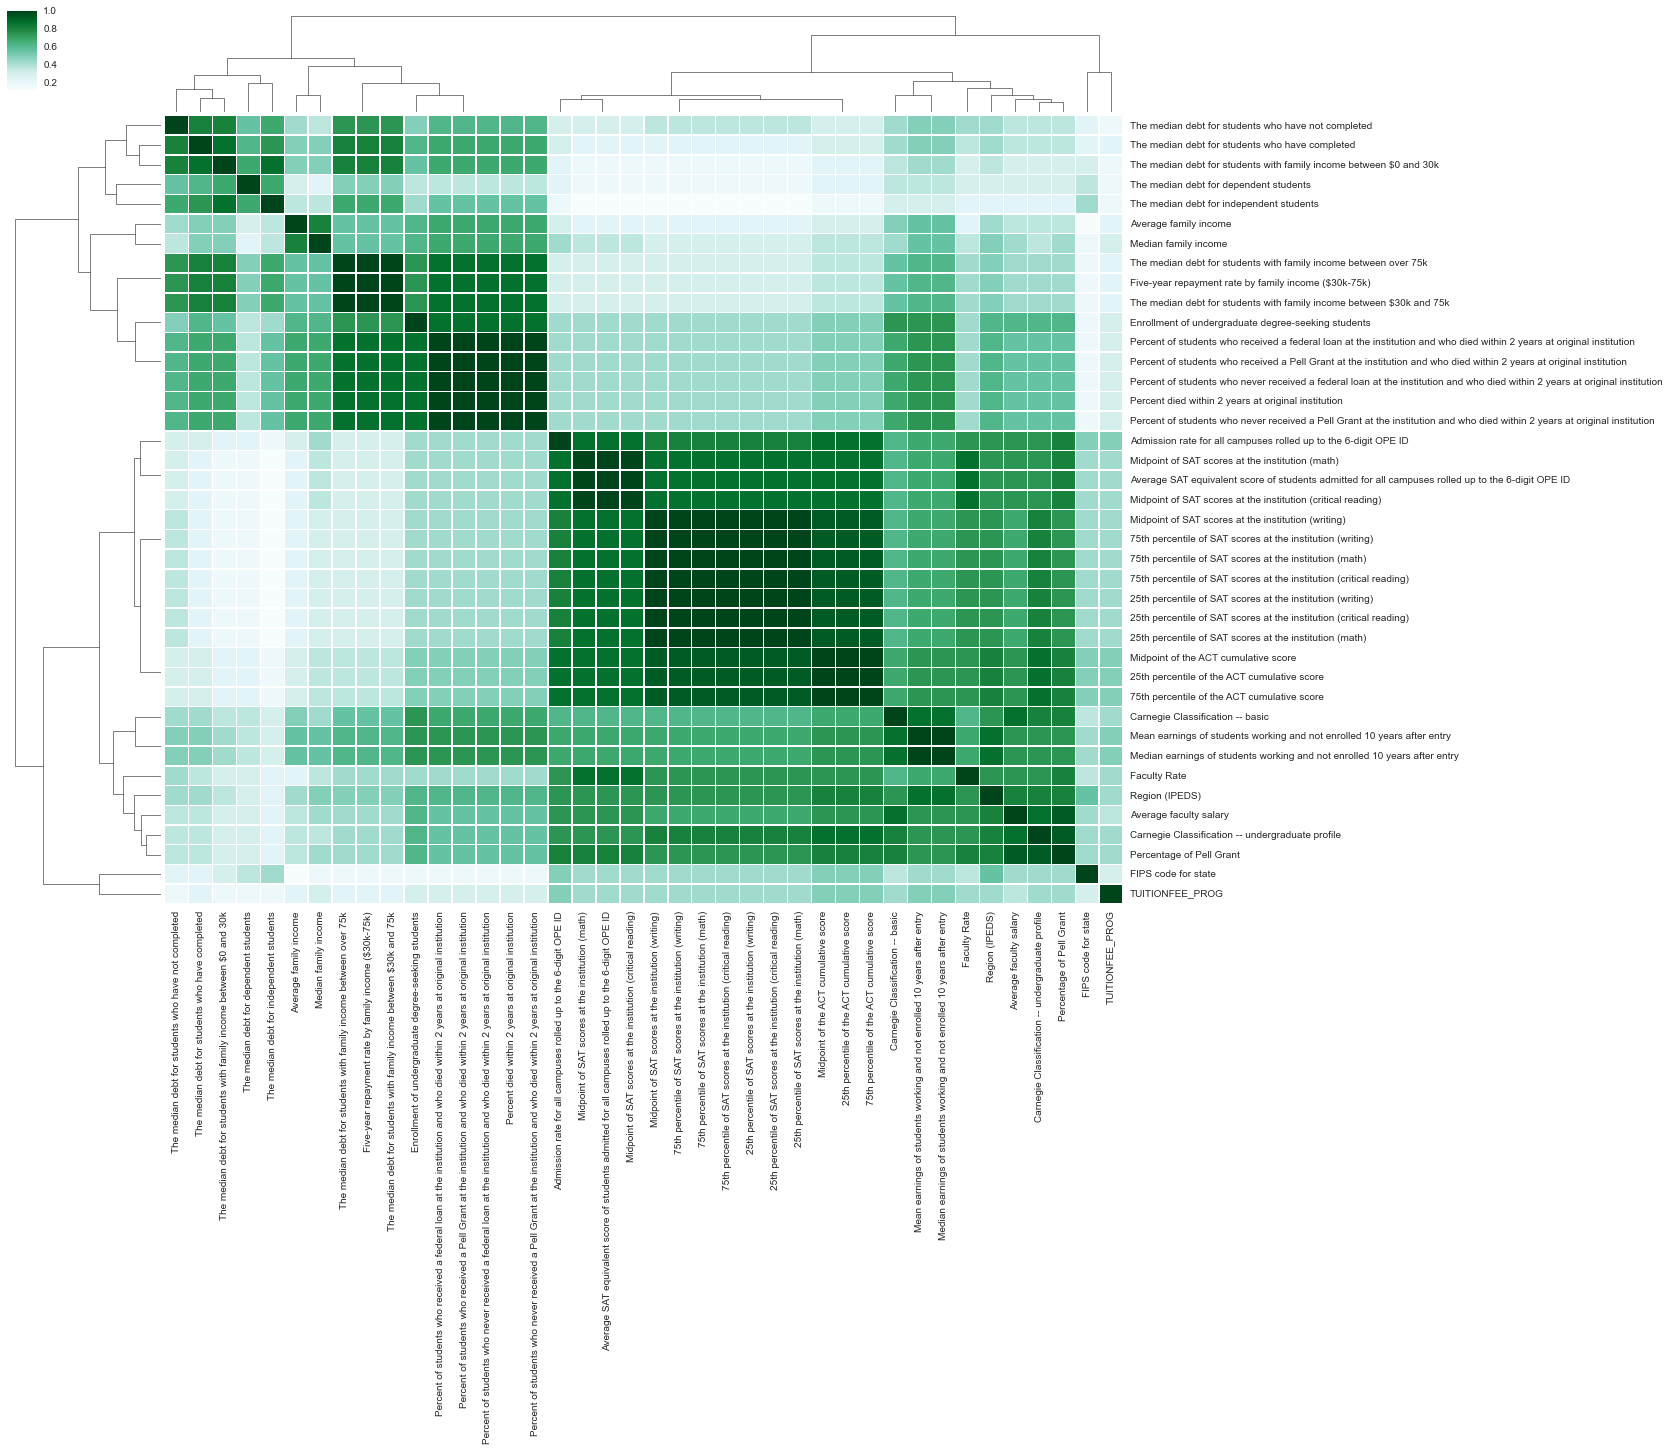

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
ed7000.heatmap(ed7000.q('''ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF %g'''))

One obvious observation is that the more rows we add, the more significant the connected components are. Even though we only analyzed the overall dataset for 11 iterations on 4 models and the subset for 100 iterations on 30 models, the heagtmap of the overall dataset show us clear dependant variables.<br>
Let's focus on them and assess the viability of our models

BQL [ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF "taball_cc"] [()]


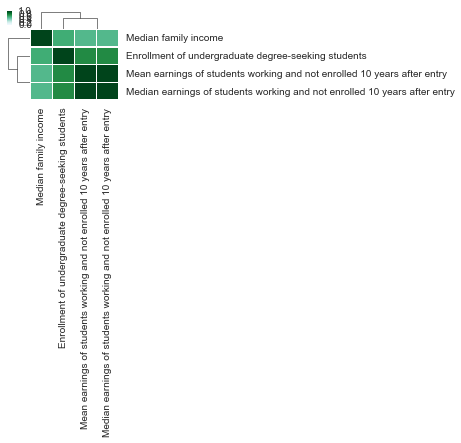

In [22]:
ed7000.heatmap(ed7000.q('''ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF %g'''), 
                 selectors={'MCAS': lambda name: 
                            "Median family income" in name 
                            or "Mean earnings of students working and not enrolled 10 years after entry" in name 
                            or "Median earnings of students working and not enrolled 10 years after entry" in name 
                            or "Enrollment of undergraduate degree-seeking students" in name                           })

In [33]:
Cols = ["Average SAT equivalent score of students admitted for all campuses rolled up to the 6-digit OPE ID",
       "Admission rate for all campuses rolled up to the 6-digit OPE ID"]

#BayesDB distribution simulation versus our intuition

In this part we will compare the intuitive distribution of `the admission rates` and `the average family income` versus the distribution that Bayes DB simulates

##Admission rate

Let's take the admission rate for all campuses.<br>
Here is how the raw data looks like: 

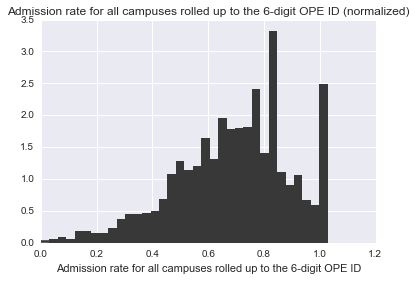

In [10]:
bdbcontrib.histogram(bdb, '''SELECT "Admission rate for all campuses rolled up to the 6-digit OPE ID"
                     FROM taball''', bins=35, normed=True);
plt.savefig("distrib_select") 

This result is pretty far from our intuition. <br>
Indeed, our intuition would say that the admission rate follow a normal distribution where most of the schools would have an average admission rate (whatever the average of that distribution might be, our intuition would say that most of the schools accept 50 to 60% of their applicants)

So now, let's simulate all the values of the admission rates and see what Bayes DB suggest us as a distribution

In [44]:
q('''
CREATE TABLE adm_rate_all AS
    SIMULATE "Admission rate for all campuses rolled up to the 6-digit OPE ID"
    FROM %g
    LIMIT 3000;
''');

BQL [
CREATE TABLE adm_rate_all AS
    SIMULATE "Admission rate for all campuses rolled up to the 6-digit OPE ID"
    FROM "tab_cc"
    LIMIT 3000;
] [()]


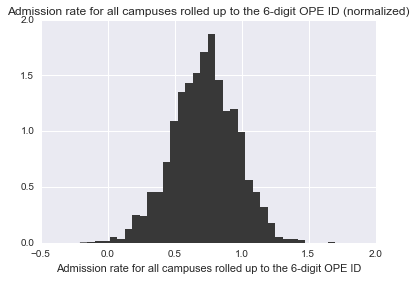

In [9]:
img = bdbcontrib.histogram(bdb, '''SELECT "Admission rate for all campuses rolled up to the 6-digit OPE ID"
                     FROM adm_rate_all''', bins=35, normed=True);
plt.savefig("distrib_sim") 

This confirms our initial intuition

Now let's see if we only infer the missing values

In [79]:
q('''drop table adm_rate_nan''')

BQL [drop table adm_rate_nan] [()]


""


In [80]:
q('''
CREATE TABLE adm_rate_nan AS
    INFER EXPLICIT "Average SAT equivalent score of students admitted for all campuses rolled up to the 6-digit OPE ID",
        PREDICT "Admission rate for all campuses rolled up to the 6-digit OPE ID" AS adm_rate
            CONFIDENCE adm_rate_conf
    FROM %g
''')

BQL [
CREATE TABLE adm_rate_nan AS
    INFER EXPLICIT "Average SAT equivalent score of students admitted for all campuses rolled up to the 6-digit OPE ID",
        PREDICT "Admission rate for all campuses rolled up to the 6-digit OPE ID" AS adm_rate
            CONFIDENCE adm_rate_conf
    FROM "tab_cc"
] [()]


""


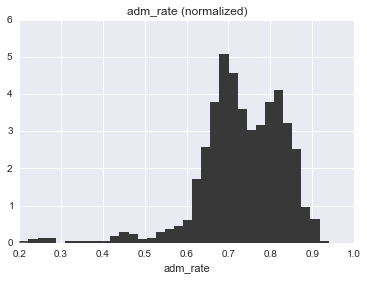

In [11]:
bdbcontrib.histogram(bdb, '''SELECT adm_rate
                     FROM adm_rate_nan''', bins=35, normed=True);
plt.savefig("distrib_infer") 

If I only infer the missing values, the distribution seems to be bimodal.<br>
As if the missing values were distibuted independantly of the previous known data and were forming a new normal distribution. The juxtaposition of the both giving our bimodal like shape.

##Average family income

The distribution of annual household income in the US is known to be this shape

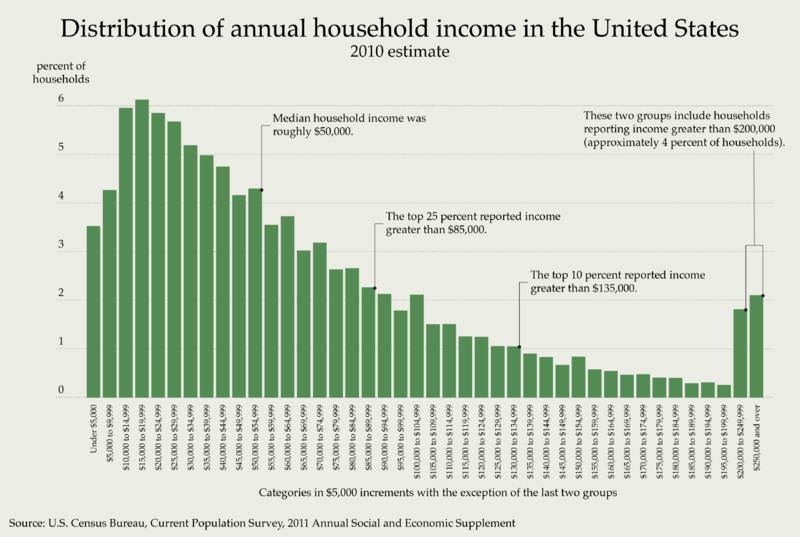

In [100]:
from IPython.display import Image
Image(filename='tail.png') 

Here is how our distribution of average family income looks like

In [16]:
bdb = bayeslite.bayesdb_open("dfall.bdb", builtin_metamodels=False)

In [20]:
import pandas as pd
import crosscat
from bdbcontrib.recipes import quickstart
import bayeslite
from bayeslite.read_pandas import bayesdb_read_pandas_df
DATA = pd.read_csv("Most+Recent+Cohorts+(All+Data+Elements).csv", delimiter=',', low_memory = False)
dfa =DATA.loc[:,['PFTFAC','UGDS','CCUGPROF','CCBASIC','locale2','region','st_fips','ACTCM75','ACTCMMID','ACTCM25','SAT_AVG_ALL','SATWR75','SATWRMID','SATWR25','SATMT75','SATMTMID','SATMT25','SATVR75','SATVRMID','SATVR25','ADM_RATE_ALL','WOMENONLY','MENONLY','AANAPII','PBI','md_earn_wne_p10','mn_earn_wne_p10','md_faminc','faminc','TUITIONFEE_PROG','AVGFACSAL','PCTPELL','IND_DEBT_MDN','HI_INC_DEBT_MDN','MD_INC_DEBT_MDN','LO_INC_DEBT_MDN','WDRAW_DEBT_MDN','GRAD_DEBT_MDN','MD_INC_RPY_5YR_RT','NOLOAN_COMP_ORIG_YR2','LOAN_COMP_ORIG_YR2','NOPELL_COMP_ORIG_YR2','PELL_COMP_ORIG_YR2','HI_INC_COMP_ORIG_Y','MD_INC_COMP_ORIG_Y','LO_INC_COMP_ORIG_Y','DEATH_YR2_RT','NOLOAN_ENRL_ORIG_YR','NOLOAN_DEATH_YR2_RT','LOAN_DEATH_YR2_RT','NOPELL_DEATH_YR2_RT','PELL_DEATH_YR2_RT','HI_INC_DEATH_YR2_R','MD_INC_DEATH_YR2_R','LO_INC_DEATH_YR2_R','DEP_DEBT_MDN']] 
dfa.columns = ['Faculty Rate','Enrollment of undergraduate degree-seeking students','Carnegie Classification -- undergraduate profile','Carnegie Classification -- basic','Degree of urbanization of institution','Region (IPEDS)','FIPS code for state','75th percentile of the ACT cumulative score','Midpoint of the ACT cumulative score','25th percentile of the ACT cumulative score','Average SAT equivalent score of students admitted for all campuses rolled up to the 6-digit OPE ID','75th percentile of SAT scores at the institution (writing)','Midpoint of SAT scores at the institution (writing)','25th percentile of SAT scores at the institution (writing)','75th percentile of SAT scores at the institution (math)','Midpoint of SAT scores at the institution (math)','25th percentile of SAT scores at the institution (math)','75th percentile of SAT scores at the institution (critical reading)','Midpoint of SAT scores at the institution (critical reading)','25th percentile of SAT scores at the institution (critical reading)','Admission rate for all campuses rolled up to the 6-digit OPE ID','Flag for women-only college','Flag for men-only college','Flag for Asian American Native American Pacific Islander-serving institution','Flag for predominantly black institution','Median earnings of students working and not enrolled 10 years after entry','Mean earnings of students working and not enrolled 10 years after entry','Median family income','Average family income','TUITIONFEE_PROG','Average faculty salary','Percentage of Pell Grant','The median debt for independent students','The median debt for students with family income between over 75k','The median debt for students with family income between $30k and 75k','The median debt for students with family income between $0 and 30k','The median debt for students who have not completed','The median debt for students who have completed','Five-year repayment rate by family income ($30k-75k)','Percent of students who never received a federal loan at the institution and who were still enrolled at original institution within 2 years','Percent of students who received a federal loan at the institution and who completed in 2 years ','Percent of students who did not receive a Pell Grant at the institution and who completed in 2 years at original ','Percent of students who received a Pell Grant at the institution and who completed in 2 years at original ','Percent of high-income (over in nominal family income) students who died within a year','Percent of middle-income (between $30k and 75k in nominal family income) students who died within a year','Percent of female students who transferred to a 2-year institution and whose status is unknown within 8 years','Percent died within 2 years at original institution','Percent of students who never received a federal loan at the institution and who were still enrolled at original institution within a year','Percent of students who never received a federal loan at the institution and who died within 2 years at original institution','Percent of students who received a federal loan at the institution and who died within 2 years at original institution','Percent of students who never received a Pell Grant at the institution and who died within 2 years at original institution','Percent of students who received a Pell Grant at the institution and who died within 2 years at original institution','Percent of high income (more than 75k in nominal family income) students who died within 2 years','Percent of middle-income (between $30k and 75k in nominal family income) students who died within 2 years','Percent of low income (between 0 and 30k in nominal family income) students who died within 2 years','The median debt for dependent students']
dfa = dfa.iloc[:,:]
bayesdb_read_pandas_df(bdb, "all", dfa, create=True)

In [21]:
edall = quickstart(name='all', bdb_path='dfall.bdb')

BQL [SELECT COUNT(*) FROM "all"] [()]
BQL [
        CREATE GENERATOR "all_cc" IF NOT EXISTS FOR "all" USING crosscat( GUESS(*) )] [()]


In [24]:
q = edall.q

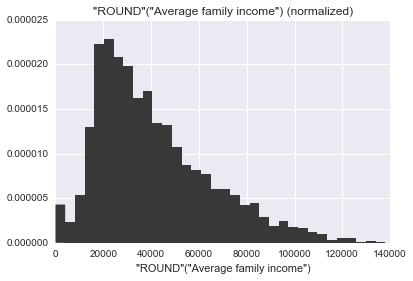

In [22]:
bdbcontrib.histogram(bdball, '''SELECT ROUND("Average family income")
                     FROM all''', bins=35, normed=True);

It seems like the tail of the shape is fitting our assumption but the beginning of the distribution is somehow confusing.<br>
This has to be caused by the 1993 missing values (cf. `SELECT COUNT` below)

In [27]:
q('''select count("Average family income") from all''')

BQL [select count("Average family income") from all] [()]


,"""count""(""Average family income"")"
0,5811


Let's simulate all the missing values and plot the distribution again

In [29]:
q('''
CREATE TABLE income_all AS
    SIMULATE "Average family income"
    FROM %g
    LIMIT 7804;
''');

BQL [
CREATE TABLE income_all AS
    SIMULATE "Average family income"
    FROM "all_cc"
    LIMIT 7804;
] [()]


ERROR: 
Traceback (most recent call last):

  File "/Applications/Bayeslite-v0.1.6rc0.app/Contents/MacOS/venv/lib/python2.7/site-packages/bdbcontrib/recipes.py", line 149, in query
    res = self.bdb.execute(query_string, bindings)

  File "/Applications/Bayeslite-v0.1.6rc0.app/Contents/MacOS/venv/lib/python2.7/site-packages/bayeslite/bayesdb.py", line 215, in execute
    self.tracer, self._do_execute, string, bindings)

  File "/Applications/Bayeslite-v0.1.6rc0.app/Contents/MacOS/venv/lib/python2.7/site-packages/bayeslite/bayesdb.py", line 223, in _maybe_trace
    return meth(string, bindings)

  File "/Applications/Bayeslite-v0.1.6rc0.app/Contents/MacOS/venv/lib/python2.7/site-packages/bayeslite/bayesdb.py", line 264, in _do_execute
    cursor = bql.execute_phrase(self, phrase, bindings)

  File "/Applications/Bayeslite-v0.1.6rc0.app/Contents/MacOS/venv/lib/python2.7/site-packages/bayeslite/bql.py", line 173, in execute_phrase
    colnos, modelno=modelno, numpredictions=nsamples):

 

In [30]:
bdbcontrib.histogram(bdb, '''SELECT ROUND("Average family income")
                     FROM income_all''', bins=35, normed=True);

ERROR: An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 36))



SQLError: SQLError: no such table: income_all

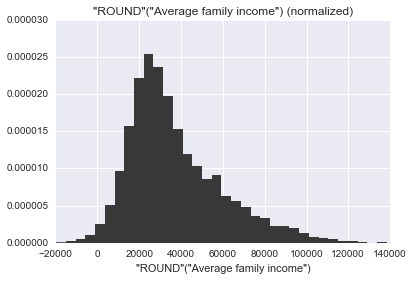

In [13]:
bdbcontrib.histogram(bdb, '''SELECT ROUND("Average family income")
                     FROM income_all''', bins=35, normed=True);
plt.savefig("distrib_faminc_sim") 

As you can see (consider only positive values), the head of the distribution has been smoothed by the model<br>
Though, the end of the tail, representing the little percentage of highly rich family does not seem to appear in our data. This is quite normal since there are no case of university where only highly rich family put their children in. In other words, the family income is always averaged for each school given the fact that all kind of wealth are represented accross the country